In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import glob
from spacepy import pycdf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score, mutual_info_score)
from matplotlib import patches

import utils
from tensorflow.keras.models import load_model

REGIONS = [387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
								83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
								62, 327, 293, 241, 107, 55, 111]

features = ['dbht_median', 'MAGNITUDE_median', 'MAGNITUDE_std', 'sin_theta_std', 'cos_theta_std', 'cosMLT', 'sinMLT',
					'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'proton_density', 'logT']

2024-06-15 15:08:05.294207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open('../../../../data/mike_working_dir/identifying_regions_data/adjusted_regions.pkl', 'rb') as f:
		regions = pickle.load(f)
with open('../../../../data/mike_working_dir/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl', 'rb') as f:
		stats = pickle.load(f)

In [3]:
results_dict = {}
thresholds = [0.5, 0.75, 0.9, 0.99]
for region in REGIONS:
	if (os.path.exists(f'outputs/rsd/non_twins_modeling_region_{region}_version_final_2.feather')) and (os.path.exists(f'outputs/rsd/twins_modeling_region_{region}_version_final.feather')):
		print(f'Loading region {region}....')

		results_dict[region] = {}
		results_dict[region]['non_twins_results'] = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_final_2.feather')
		results_dict[region]['non_twins_results']['error'] = results_dict[region]['non_twins_results']['predicted_mean'] - results_dict[region]['non_twins_results']['actual']
		results_dict[region]['twins_results'] = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_final.feather')
		results_dict[region]['twins_results']['error'] = results_dict[region]['twins_results']['predicted_mean'] - results_dict[region]['twins_results']['actual']
		mlat = utils.getting_mean_lat(regions[f'region_{region}']['station'])
		results_dict[region]['mlat'] = mlat
		results_dict[region]['max_rsd'] = stats[f'region_{region}']['max_rsd']

		thresh = []
		for threshold in thresholds:
			thresh.append(results_dict[region]['max_rsd']['max_rsd'].quantile(threshold))
		results_dict[region]['thresholds'] = thresh

	elif (os.path.exists(f'outputs/rsd/non_twins_modeling_region_{region}_version_final_2.feather')) and not (os.path.exists(f'outputs/rsd/twins_modeling_region_{region}_version_final.feather')):
		results_dict[region] = {}
		results_dict[region]['non_twins_results'] = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_final_2.feather')
		results_dict[region]['non_twins_results']['error'] = results_dict[region]['non_twins_results']['predicted_mean'] - results_dict[region]['non_twins_results']['actual']
		mlat = utils.getting_mean_lat(regions[f'region_{region}']['station'])
		results_dict[region]['mlat'] = mlat
		results_dict[region]['max_rsd'] = stats[f'region_{region}']['max_rsd']

		thresh = []
		for threshold in thresholds:
			thresh.append(results_dict[region]['max_rsd']['max_rsd'].quantile(threshold))
		results_dict[region]['thresholds'] = thresh

	else:
		print(f'Results do not exist for both model types for region {region}. Skipping....')
		continue

Loading region 387....
Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station KIR....
Loading station PEL....
Results do not exist for both model types for region 61. Skipping....
Results do not exist for both model types for region 202. Skipping....
Results do not exist for both model types for region 287. Skipping....
Results do not exist for both model types for region 207. Skipping....
Results do not exist for both model types for region 361. Skipping....
Results do not exist for both model types for region 137. Skipping....
Results do not exist for both model types for region 184. Skipping....
Results do not exist for both model types for region 36. Skipping....
Results do not exist for both model types for region 19. Skipping....
Results do not exist for both model types for region 9. Skipping....
Results do not exist for both model types for region 163. Skipping....
Results do not exist for both model types for region 16. Skipping....
Results do 

In [4]:
selected_region = 'JPN-0'

# torch_model = pd.read_feather('../including_ion_temp_maps/outputs/rsd/non_twins_modeling_region_FSC-4_version_reproducing_keras.feather')
swmag_results = pd.read_feather(f'../including_ion_temp_maps/outputs/rsd/non_twins_modeling_region_{selected_region}_version_swmag_v6-oversampling.feather')
twins_results = pd.read_feather(f'../including_ion_temp_maps/outputs/rsd/twins_modeling_region_{selected_region}_version_twins_v_maxpooling_oversampling.feather')

In [11]:
snum = 10000
enum = snum +5
print(torch_classification_v6)

print(f'ratio of positive to negative samples: {torch_classification_v6["actual"].sum() / len(torch_classification_v6)}')

       predicted_mean  predicted_std  actual               dates
0            0.312894       0.528094     1.0 2010-05-28 00:40:00
1            0.309107       0.525201     1.0 2010-05-28 00:41:00
2            0.313380       0.526416     1.0 2010-05-28 00:42:00
3            0.307445       0.523000     1.0 2010-05-28 00:43:00
4            0.306690       0.522427     1.0 2010-05-28 00:44:00
...               ...            ...     ...                 ...
20234        0.229065       0.257996     1.0 2017-05-28 00:15:00
20235        0.243658       0.269506     1.0 2017-05-28 00:16:00
20236        0.200877       0.249649     1.0 2017-05-28 00:17:00
20237        0.233902       0.266430     1.0 2017-05-28 00:18:00
20238        0.228520       0.258217     1.0 2017-05-28 00:19:00

[20239 rows x 4 columns]
ratio of positive to negative samples: 0.2745689016255744


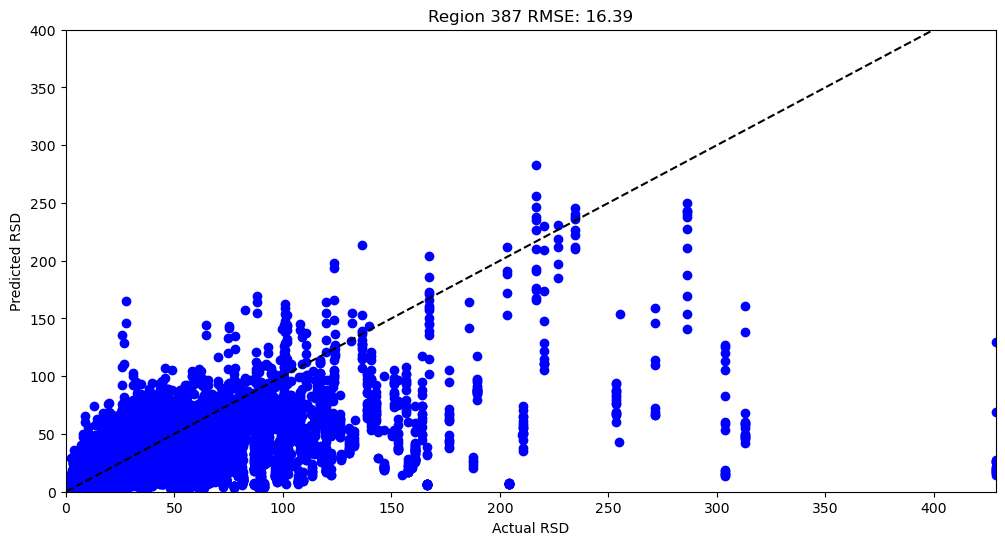

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.scatter(results_dict[241]['non_twins_results']['actual'], results_dict[241]['non_twins_results']['predicted_mean'], color='blue', label='keras')
# axes.scatter(torch_model['actual'], torch_model['predicted_mean'], color='red', label='torch')
axes.plot([0, 400], [0, 400], color='black', linestyle='--')
axes.set_xlabel('Actual RSD')
axes.set_ylabel('Predicted RSD')
axes.set_title(f'Region 387 RMSE: {np.sqrt(mean_squared_error(results_dict[241]["non_twins_results"]["actual"], results_dict[241]["non_twins_results"]["predicted_mean"])):.2f}')
plt.margins(x=0, y=0)
plt.show()

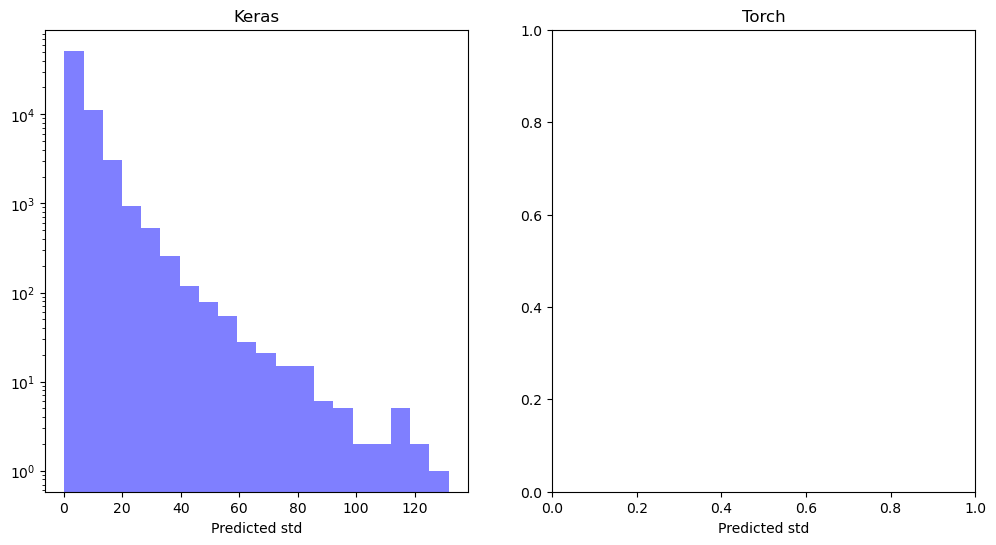

In [13]:
std_keras = np.std(results_dict[62]['non_twins_results']['actual'])
# std_torch = np.std(torch_model['actual'])

# print(f'Keras std: {std_keras}\tTorch std: {std_torch}')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(results_dict[62]['non_twins_results']['predicted_std'], bins=20, color='blue', alpha=0.5, label='keras', log=True)
# axes[1].hist(torch_model['predicted_std'], bins=20, color='red', alpha=0.5, label='torch', log=True)
axes[0].set_title('Keras')
axes[1].set_title('Torch')
axes[0].set_xlabel('Predicted std')
axes[1].set_xlabel('Predicted std')
plt.show()

In [5]:
# keras_model = results_dict[241]['non_twins_results']

# keras_model.set_index('dates', inplace=True)
# torch_model.set_index('dates', inplace=True)
swmag_results.set_index('dates', inplace=True)
twins_results.set_index('dates', inplace=True)

In [9]:
print(f'Region: {selected_region}')
prec, rec, __ = precision_recall_curve(y_true=swmag_results['actual'], probas_pred=swmag_results['predicted_mean'])
f1 = 2 * (prec * rec) / (prec + rec)
area = auc(rec, prec)
MI = mutual_info_score(swmag_results['actual'], swmag_results['predicted_mean'])
print(f'SWMAG: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}\tMI: {round(MI, 4)}')

prec, rec, __ = precision_recall_curve(y_true=twins_results['actual'], probas_pred=twins_results['predicted_mean'])
f1 = 2 * (prec * rec) / (prec + rec)
area = auc(rec, prec)
MI = mutual_info_score(twins_results['actual'], twins_results['predicted_mean'])
print(f'TWIN: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}\tMI: {round(MI, 4)}')

Region: JPN-0
SWMAG: 	F1: 0.452	AUC: 0.4059	MI: 0.5874
TWIN: 	F1: 0.4515	AUC: 0.4282	MI: 0.5875


/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Autoencoder: F1: 0.67518334516
				AUC: 0.77291124815
Non-Twins: F1: 0.746011487
			AUC: 0.809602034
Maxpooling: F1: 0.70027881
				AUC: 0.7797591746
				

In [163]:
for cluster in cluster_dict.values():
	for region in cluster['regions'].keys():
		if key != 'GRL-0':
			continue
		else: 
			mlat = cluster['regions'][region]['mlat']

NameError: name 'cluster_dict' is not defined

Region: FSC-1
SWMAG: 	F1: 0.8291	AUC: 0.899	MI: 0.4693
TWIN: 	F1: 0.8294	AUC: 0.9	MI: 0.4694
Region: ALSK
SWMAG: 	F1: 0.8271	AUC: 0.8894	MI: 0.5066
TWIN: 	F1: 0.8314	AUC: 0.8949	MI: 0.5066
Region: GRL-3
SWMAG: 	F1: 0.7629	AUC: 0.8457	MI: 0.4922
TWIN: 	F1: 0.7602	AUC: 0.8457	MI: 0.4923


/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label,

Region: CAN-2
SWMAG: 	F1: 0.8857	AUC: 0.9397	MI: 0.4795
TWIN: 	F1: 0.8866	AUC: 0.941	MI: 0.4793
Region: CEU-1
SWMAG: 	F1: 0.7098	AUC: 0.7991	MI: 0.5782
TWIN: 	F1: 0.7134	AUC: 0.7986	MI: 0.5782
Region: JPN-1


/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label,

SWMAG: 	F1: 0.4969	AUC: 0.5213	MI: 0.5643
TWIN: 	F1: 0.4879	AUC: 0.4848	MI: 0.5643


/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


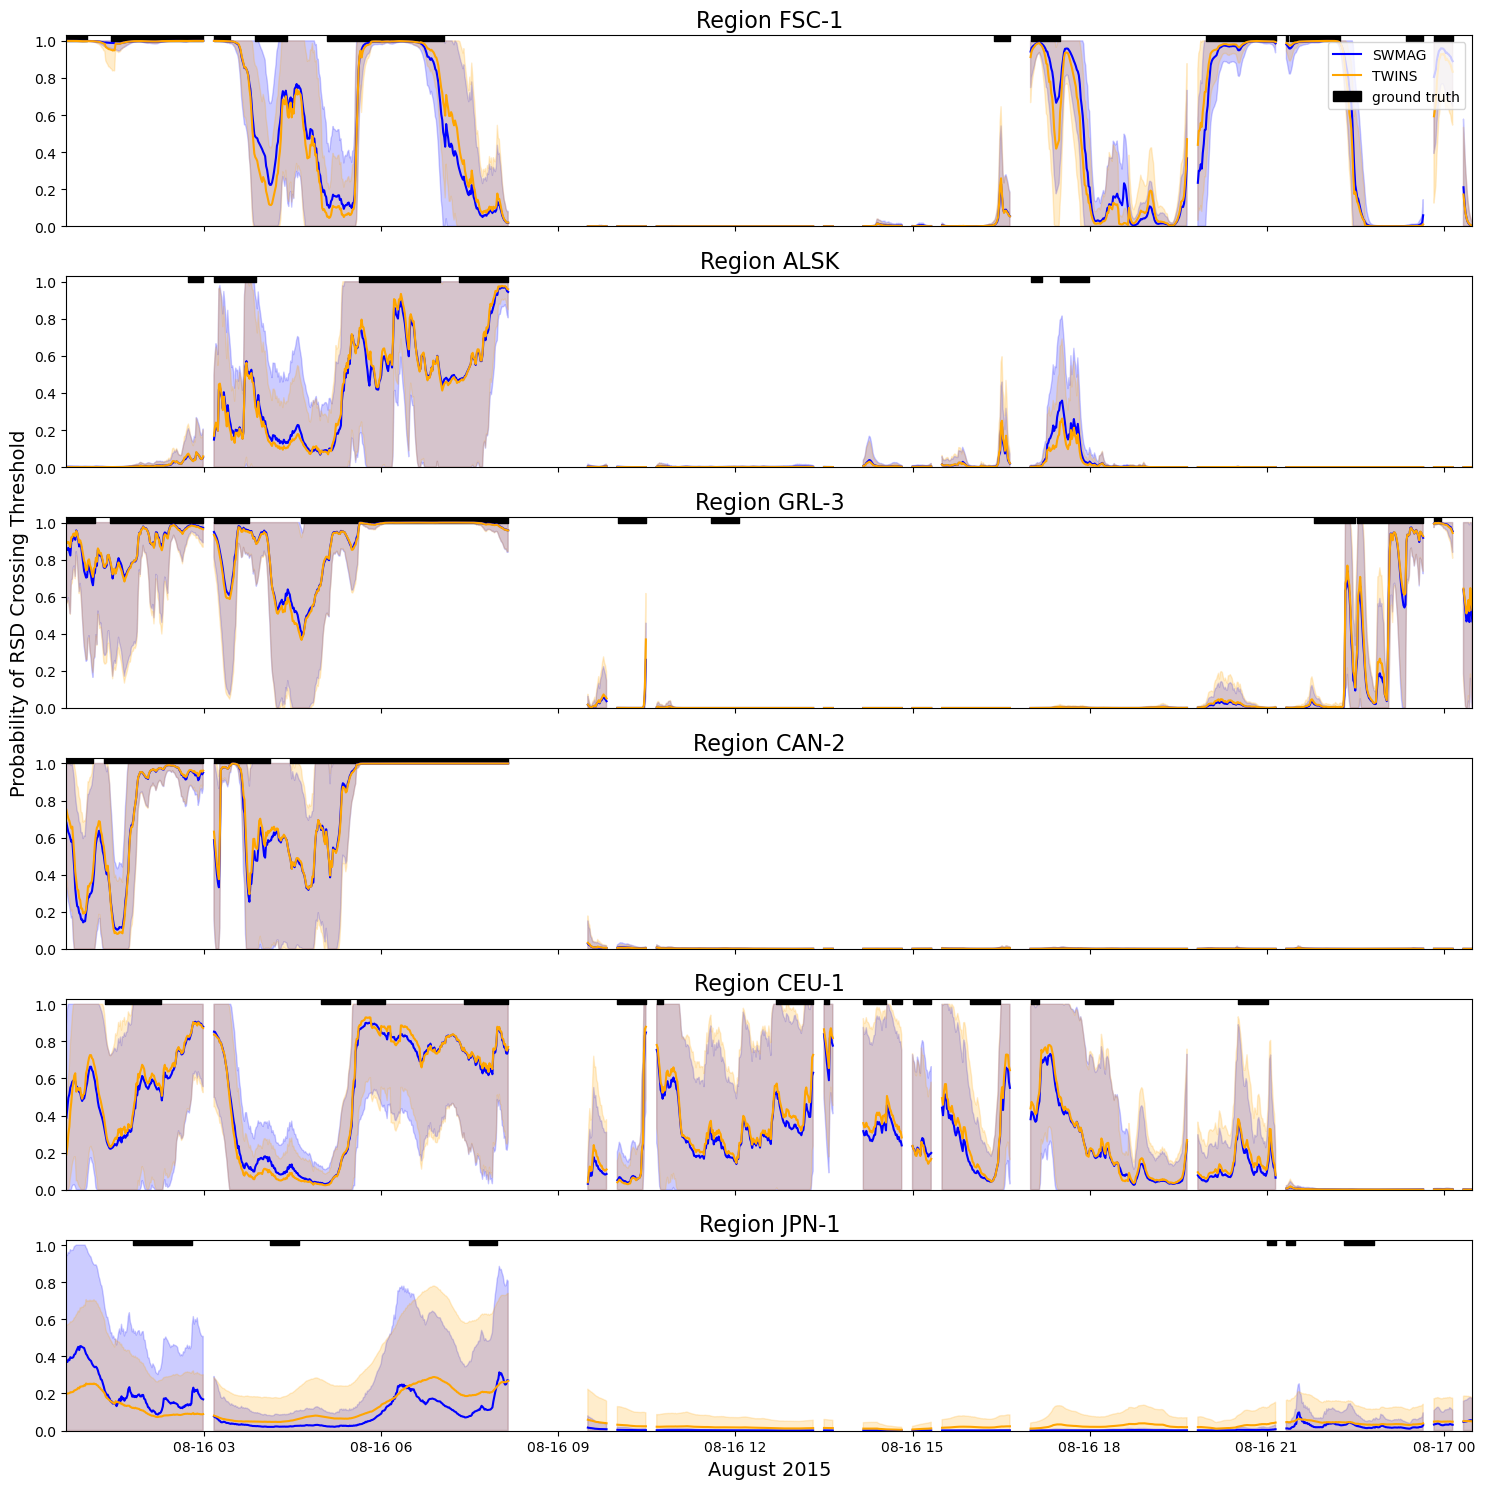

In [162]:
selected_region = 'FSC-6'

def preparing_results_plotting(region):

	list_oversampled = ['JPN-0', 'GRL-1', 'GRL-2', 'SVLB']
	if region in list_oversampled:
		swmag_results = pd.read_feather(f'../including_ion_temp_maps/outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-oversampling.feather')
		twins_results = pd.read_feather(f'../including_ion_temp_maps/outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
	else:
		swmag_results = pd.read_feather(f'../including_ion_temp_maps/outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-1.feather')
		twins_results = pd.read_feather(f'../including_ion_temp_maps/outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')

	swmag_results.set_index('dates', inplace=True)
	twins_results.set_index('dates', inplace=True)

	print(f'Region: {sel_reg}')
	prec, rec, __ = precision_recall_curve(y_true=swmag_results['actual'], probas_pred=swmag_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	MI = mutual_info_score(swmag_results['actual'], swmag_results['predicted_mean'])
	print(f'SWMAG: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}\tMI: {round(MI, 4)}')

	prec, rec, __ = precision_recall_curve(y_true=twins_results['actual'], probas_pred=twins_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	MI = mutual_info_score(twins_results['actual'], twins_results['predicted_mean'])
	print(f'TWIN: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}\tMI: {round(MI, 4)}')

	start_date = '2015-08-10 00:00:00'
	end_date = '2015-08-20 12:00:00'
	# start_date = '2012-03-06 00:00:00'
	# end_date = '2012-03-10 12:00:00'

	plotting_range = pd.date_range(start_date, end_date, freq='min')
	plotting_df = pd.DataFrame(index=plotting_range)
	plotting_df = plotting_df.join(swmag_results['actual'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_mean'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_std'], how='left')
	plotting_df = plotting_df.join(twins_results['predicted_mean'], how='left', rsuffix='_twins')
	plotting_df = plotting_df.join(twins_results['predicted_std'], how='left', rsuffix='_twins')
	plotting_df['swmag_fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
	plotting_df['swmag_fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
	plotting_df['twins_fill_bottom'] = plotting_df['predicted_mean_twins'] - plotting_df['predicted_std_twins']
	plotting_df['twins_fill_top'] = plotting_df['predicted_mean_twins'] + plotting_df['predicted_std_twins']
	plotting_df.clip(lower=0, upper=1, inplace=True)
	plotting_df['bottom'] = plotting_df['actual']*1.00
	plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

selected_regions = ['FSC-1', 'ALSK', 'GRL-3', 'CAN-2', 'CEU-1', 'JPN-1']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_results_plotting(sel_reg)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean'], color='blue', label='SWMAG')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'swmag_fill_bottom'], plotting_df.loc[start_date:end_date, 'swmag_fill_top'], color='blue', alpha=0.2)
	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_twins'], color='orange', label='TWINS')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'twins_fill_bottom'], plotting_df.loc[start_date:end_date, 'twins_fill_top'], color='orange', alpha=0.2)
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	axes[i].set_title(f'Region {sel_reg}', fontsize=16)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.001,1.03)

axes[0].legend(loc='upper right')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=14)
axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=14)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'../including_ion_temp_maps/plots/GEM_2024_plots/regions_example.png')


# fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# axes.plot(swmag_results['actual'], color='blue', label='actual')
# axes.plot(swmag_results['predicted_mean'], color='red', label='predicted')
# axes.fill_between(swmag_results.index, swmag_results['predicted_mean'] - swmag_results[ 'predicted_std'], swmag_results['predicted_mean'] + swmag_results['predicted_std'], color='red', alpha=0.3)
# axes.set_title('Torch classification')
# plt.show()


In [11]:
total_df = pd.DataFrame()
for region in results_dict.keys():
	temp_df = stats[f'region_{region}']['max_rsd'].copy()
	temp_df.dropna(inplace=True)
	temp_df['mlat'] = results_dict[region]['mlat'].astype(int)
	temp_df['MLT'] = temp_df['MLT'].astype(int)
	temp_df.loc[temp_df['MLT']==24, 'MLT'] = 0
	total_df = pd.concat([total_df, temp_df], axis=0, ignore_index=True)

simplified_df = total_df.groupby(['MLT', 'mlat'])['max_rsd'].agg(['mean', 'median', 'std', 'count'])


/home/mcoughlan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


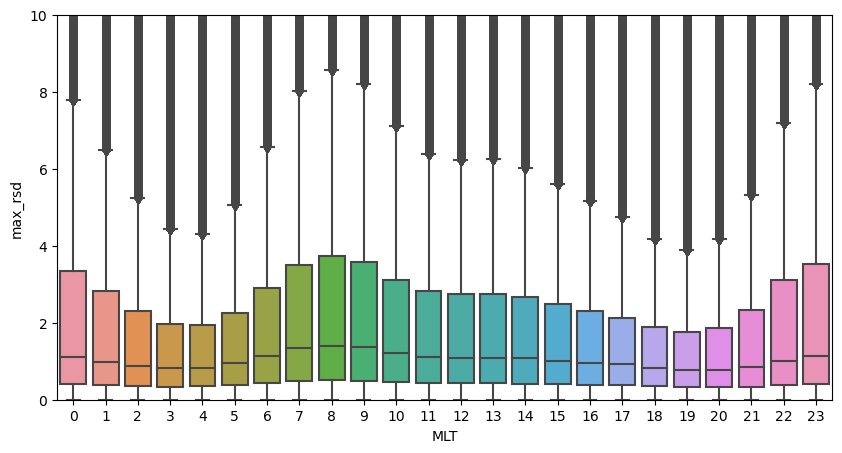

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# plotting a boxplot of max_rsd as a function of MLT
sns.boxplot(total_df["MLT"], total_df["max_rsd"])
plt.ylim(0,10)
plt.show()

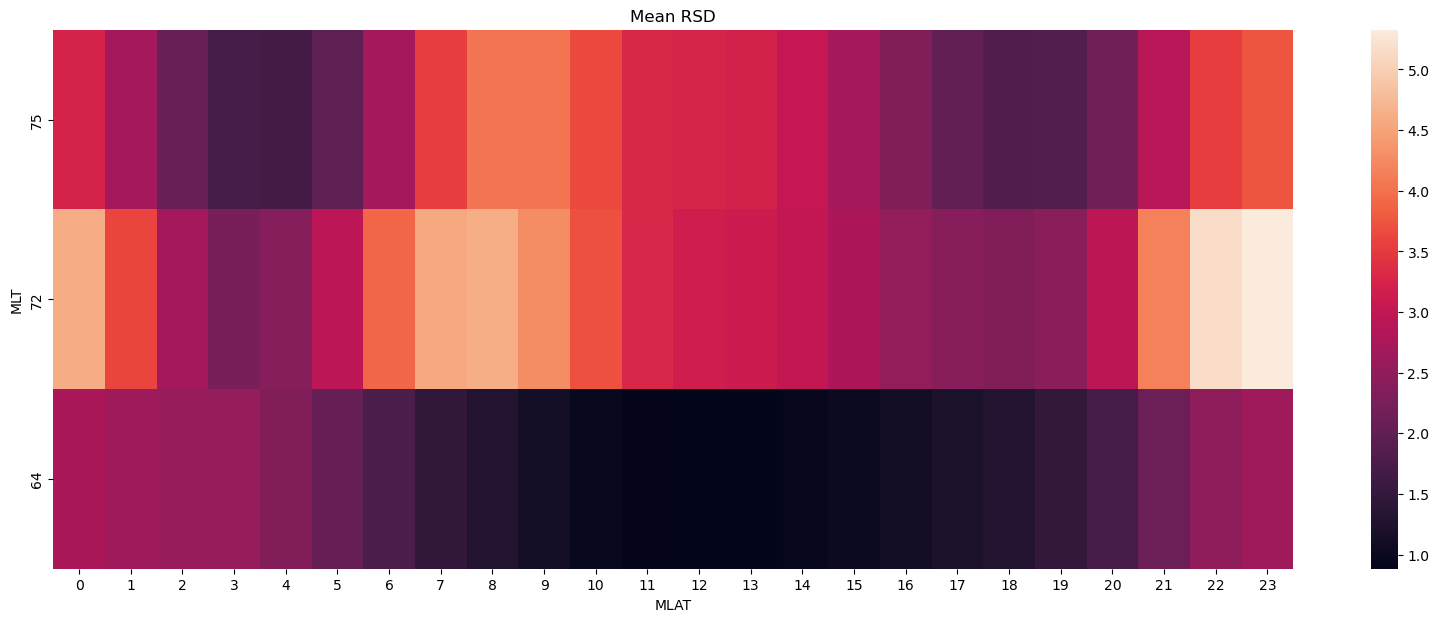

In [13]:
# transfering the grouped dataframe to a pivot table
pivot_median = simplified_df.pivot_table(index="mlat", columns="MLT", values="median")
pivot_mean = simplified_df.pivot_table(index="mlat", columns="MLT", values="mean")
pivot_std = simplified_df.pivot_table(index="mlat", columns="MLT", values="std")


# reversing the order of the pivot tabels for plotting
# pivot_median = pivot_median.iloc[::-1]
# pivot_std = pivot_std.iloc[::-1]
# pivot_mean = pivot_mean.iloc[::-1]

# plotting the pivot table with mlat on the y-axis in decending order and the MLT on the x-axis in ascending order
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax = sns.heatmap(pivot_mean, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("MLAT")
ax.set_ylabel("MLT")
ax.set_title('Mean RSD')
plt.show()

In [14]:
# manually writing a precision-recall curve for the continuious data
def continuious_precision_recall(y_true, y_pred):
    precision, recall = [], []
    for threshold in tqdm(np.linspace(0, y_pred.max(), 100)):
        y_pred_class = np.where(y_pred > threshold, 1, 0)
        y_true_class = np.where(y_true > threshold, 1, 0)
        tn, fn, fp, tp = confusion_matrix(y_true_class, y_pred_class).ravel()
        print(f'tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}')
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))

    # s1 = slice(None, None, -1)
    # precision = np.array(precision)[s1]
    # recall = np.array(recall)[s1]
    # print(precision)
    # print(recall)

    # reversing the order of the precision and recall
    precision = np.array(precision)[::-1]
    recall = np.array(recall)[::-1]
    return np.hstack((precision,1)), np.hstack((recall,0))

In [15]:
def calculating_hss(y_true, y_pred, thresholds):
	# calculating the true positive, false positive, false negative, and true negative
	hss_scores = []
	for threshold in thresholds:
		y_pred_class = np.where(y_pred > threshold, 1, 0)
		y_true_class = np.where(y_true > threshold, 1, 0)
		tn, fp, fn, tp = confusion_matrix(y_true_class, y_pred_class).ravel()
		hss = (2 * (tp * tn - fn * fp)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
		hss_scores.append(hss)
	return hss_scores

def calculating_HSS_SS(non_twins_true, twins_true, non_twins_pred, twins_pred, thresholds):
	# calculating the true positive, false positive, false negative, and true negative
	non_twins_hss_scores = []
	twins_hss_scores = []
	for threshold in thresholds:
		non_twins_pred_class = np.where(non_twins_pred > threshold, 1, 0)
		non_twins_true_class = np.where(non_twins_true > threshold, 1, 0)
		tn, fp, fn, tp = confusion_matrix(non_twins_true_class, non_twins_pred_class).ravel()
		non_twins_hss = (2 * (tp * tn - fn * fp)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
		non_twins_hss_scores.append(non_twins_hss)

		twins_pred_class = np.where(twins_pred > threshold, 1, 0)
		twins_true_class = np.where(twins_true > threshold, 1, 0)
		tn, fp, fn, tp = confusion_matrix(twins_true_class, twins_pred_class).ravel()
		twins_hss = (2 * (tp * tn - fn * fp)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
		twins_hss_scores.append(twins_hss)

	non_twins_hss_scores = np.array(non_twins_hss_scores)
	twins_hss_scores = np.array(twins_hss_scores)
	hss_ss = twins_hss_scores - non_twins_hss_scores

	return hss_ss


def calculating_RMSE_SS(y_true, y_pred):

	# calculating the root mean squared error skill score
	rmse = np.sqrt(mean_squared_error(y_true, y_pred))
	rmse_ss = (rmse / np.std(y_true))

	return rmse_ss

def calculating_comparative_RMSE(non_twins_true, twins_true, non_twins_pred, twins_pred):

	# calculating the comparative root mean squared erro_
	non_twins_rmse = np.sqrt(mean_squared_error(non_twins_true, non_twins_pred))
	twins_rmse = np.sqrt(mean_squared_error(twins_true, twins_pred))
	comparative_rmse = 1 - (twins_rmse / non_twins_rmse)

	return comparative_rmse


In [16]:
for region in results_dict.keys():
	hss_scores = pd.DataFrame(index=thresholds, columns=['twins', 'non_twins'])
	HSS_SS = pd.DataFrame(index=thresholds, columns=['HSS_SS'])
	RMSE_SS = pd.DataFrame(index=[0], columns=['twins', 'non_twins'])
	comparative_RMSE = pd.DataFrame(index=[0], columns=['comparative_RMSE'])

	hss_scores['twins'] = calculating_hss(results_dict[region]['twins_results']['actual'], results_dict[region]['twins_results']['predicted_mean'], results_dict[region]['thresholds'])
	hss_scores['non_twins'] = calculating_hss(results_dict[region]['non_twins_results']['actual'], results_dict[region]['non_twins_results']['predicted_mean'], results_dict[region]['thresholds'])
	results_dict[region]['hss_scores'] = hss_scores

	HSS_SS['HSS_SS'] = calculating_HSS_SS(results_dict[region]['non_twins_results']['actual'], results_dict[region]['twins_results']['actual'], results_dict[region]['non_twins_results']['predicted_mean'], results_dict[region]['twins_results']['predicted_mean'], results_dict[region]['thresholds'])
	results_dict[region]['HSS_SS'] = HSS_SS

	RMSE_SS['twins'] = calculating_RMSE_SS(results_dict[region]['twins_results']['actual'], results_dict[region]['twins_results']['predicted_mean'])
	RMSE_SS['non_twins'] = calculating_RMSE_SS(results_dict[region]['non_twins_results']['actual'], results_dict[region]['non_twins_results']['predicted_mean'])
	results_dict[region]['RMSE_SS'] = RMSE_SS

	comparative_RMSE['comparative_RMSE'] = calculating_comparative_RMSE(results_dict[region]['non_twins_results']['actual'], results_dict[region]['twins_results']['actual'], results_dict[region]['non_twins_results']['predicted_mean'], results_dict[region]['twins_results']['predicted_mean'])
	results_dict[region]['comparative_RMSE'] = comparative_RMSE


KeyError: 'twins_results'

In [ ]:
results_dict[387]["RMSE_SS"]["non_twins"]

0    0.677773
Name: non_twins, dtype: float64

In [ ]:
# making a figure displaying a table of the metrics results for reagion and model type
metrics_df = pd.DataFrame(columns=['MLAT', 'Non-Twins HSS (50th)', 'Twins HSS (50th)', 'Non-Twins HSS (75th)', 'Twins HSS (75th)', 'Non-Twins HSS (90th)',
									'Twins HSS (90th)', 'Non-Twins HSS (99th)', 'Twins HSS (99th)', 'Non-Twins RMSE/std', 'Twins RMSE/std'])
for region in results_dict.keys():
	metrics_df.loc[region] = [results_dict[region]['mlat'], results_dict[region]['hss_scores']['non_twins'].loc[0.50],
								results_dict[region]['hss_scores']['twins'][0.50], results_dict[region]['hss_scores']['non_twins'][0.75],
								results_dict[region]['hss_scores']['twins'][0.75], results_dict[region]['hss_scores']['non_twins'][0.90],
								results_dict[region]['hss_scores']['twins'][0.90], results_dict[region]['hss_scores']['non_twins'][0.99],
								results_dict[region]['hss_scores']['twins'][0.99], results_dict[region]['RMSE_SS']['non_twins'][0],
								results_dict[region]['RMSE_SS']['twins'][0]]

# sorting by mlat
metrics_df.sort_values(by='MLAT', inplace=True)

#rounding values in df
metrics_df = metrics_df.round(4)

# saving the metrics dataframe to a csv
metrics_df.to_csv('outputs/rsd/metrics.csv')


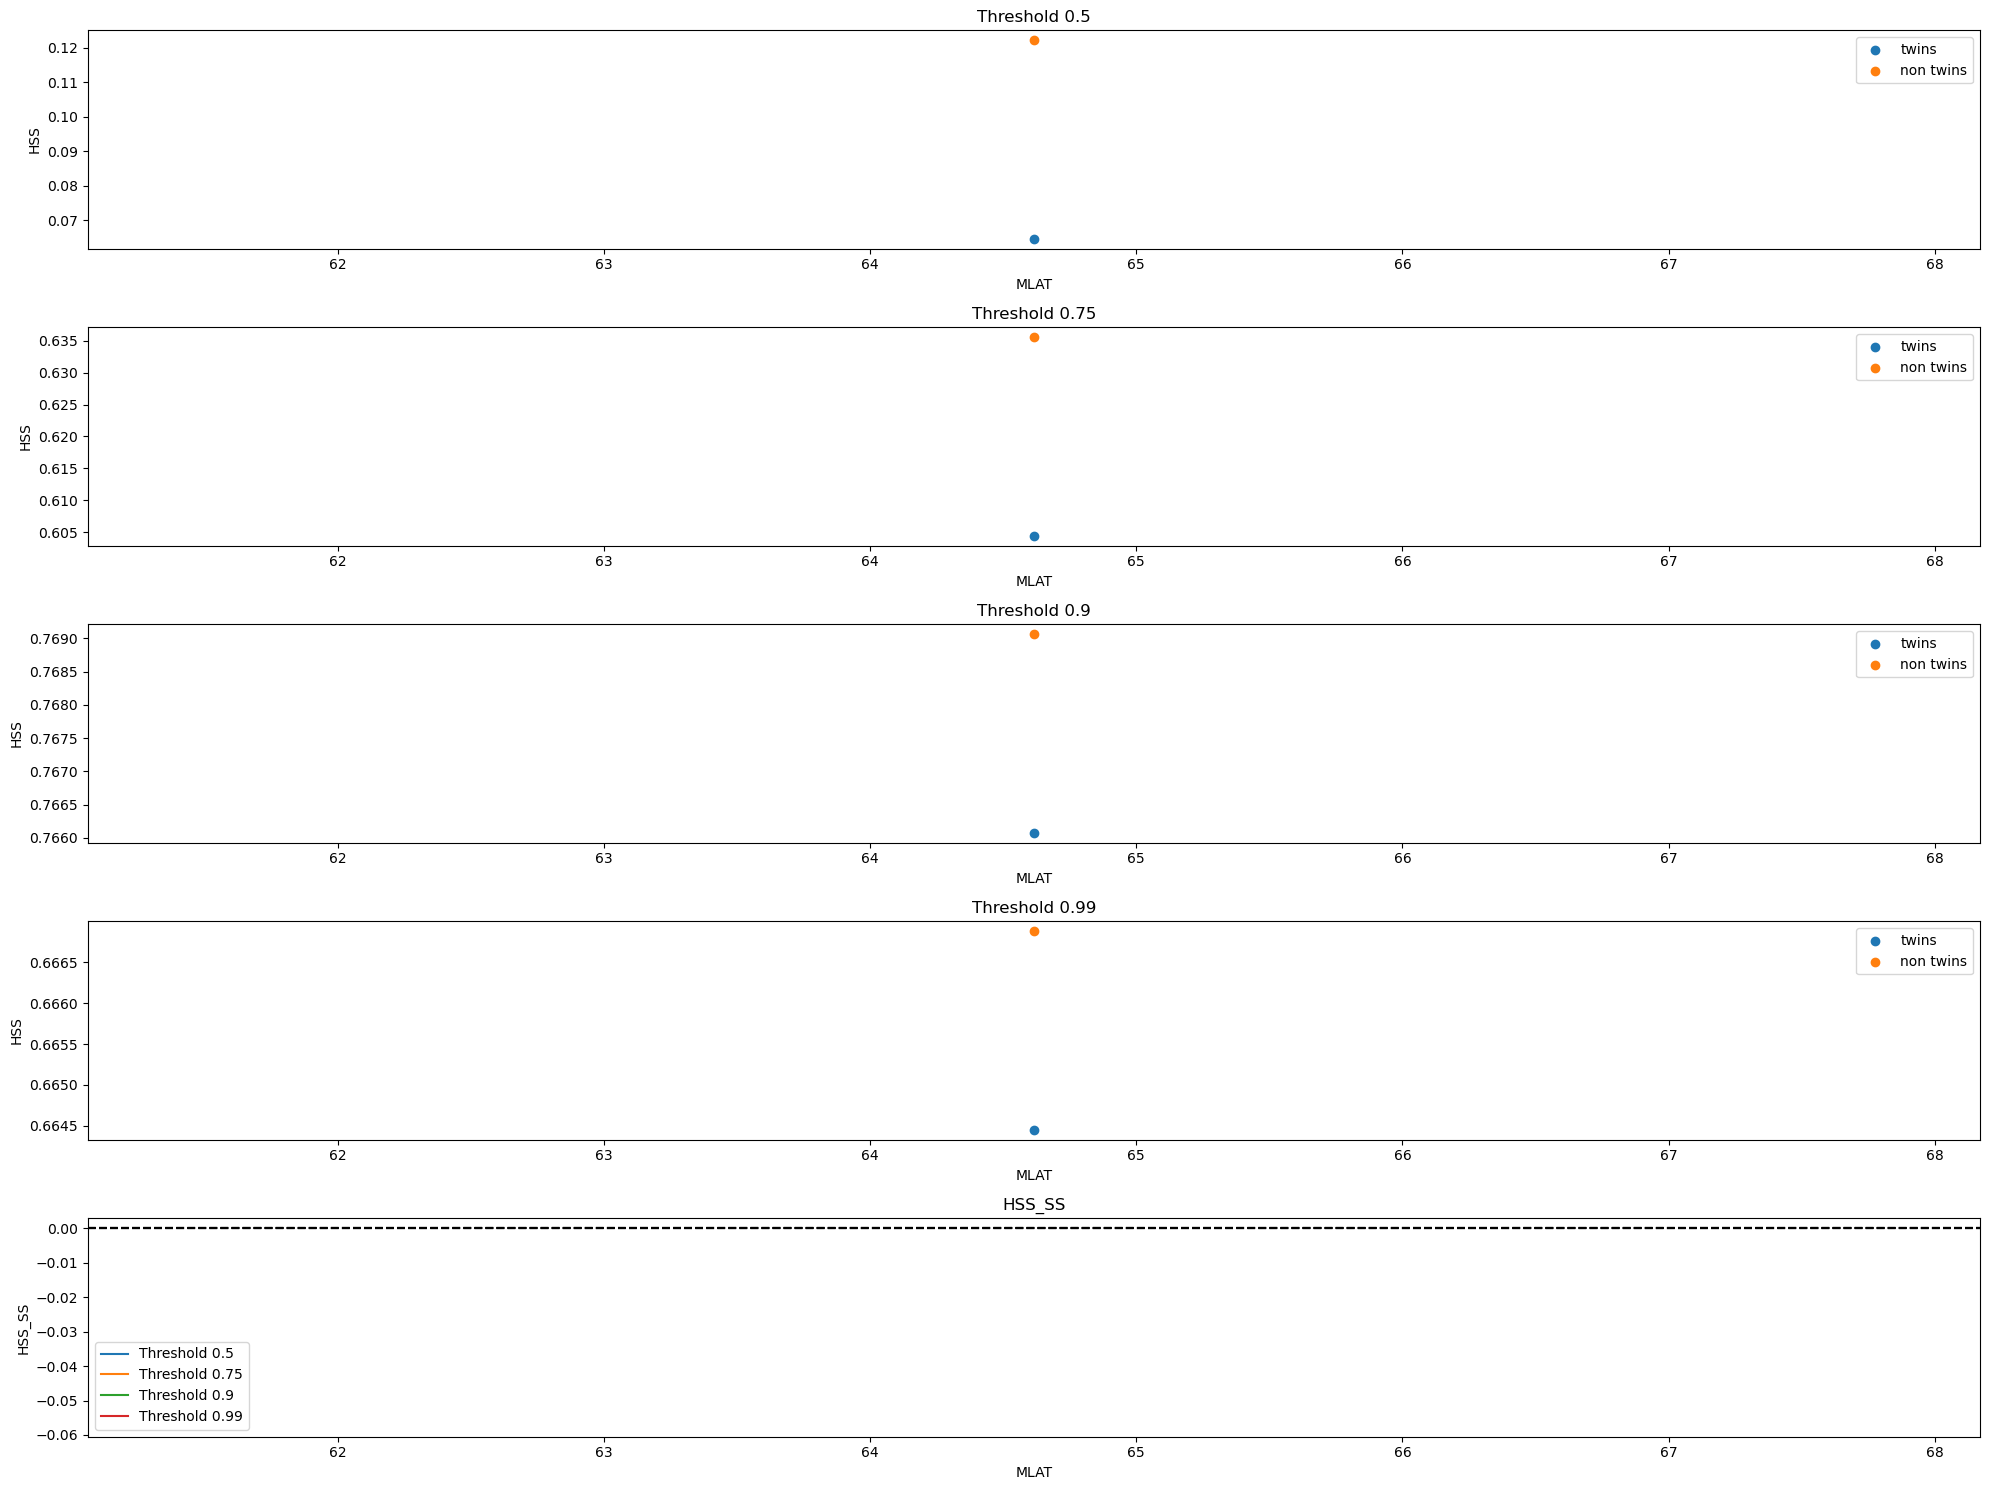

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 15))
for i, thresh in enumerate(thresholds):
	plotting_df = pd.DataFrame({'twins':[results_dict[region]['hss_scores']['twins'].loc[thresh] for region in results_dict.keys()],
								'non_twins':[results_dict[region]['hss_scores']['non_twins'].loc[thresh] for region in results_dict.keys()],
		 						'mlat':[results_dict[region]['mlat'] for region in results_dict.keys()]})
	plotting_df = plotting_df.sort_values(by='mlat')
	axes[i].scatter(plotting_df['mlat'], plotting_df['twins'], label='twins')
	axes[i].scatter(plotting_df['mlat'], plotting_df['non_twins'], label='non twins')
	axes[i].legend()
	axes[i].set_xlabel('MLAT')
	axes[i].set_ylabel('HSS')
	axes[i].set_title(f'Threshold {thresh}')

for thresh in thresholds:
	plotting_df = pd.DataFrame({'HSS_SS':[results_dict[region]['HSS_SS']['HSS_SS'].loc[thresh] for region in results_dict.keys()],
		 						'mlat':[results_dict[region]['mlat'] for region in results_dict.keys()]})
	plotting_df = plotting_df.sort_values(by='mlat')
	axes[4].plot(plotting_df['mlat'], plotting_df['HSS_SS'], label=f'Threshold {thresh}')
	axes[4].axhline(0, color='black', linestyle='--')
	axes[4].legend()
	axes[4].set_xlabel('MLAT')
	axes[4].set_ylabel('HSS_SS')
	axes[4].set_title('HSS_SS')

plt.tight_layout()
plt.show()


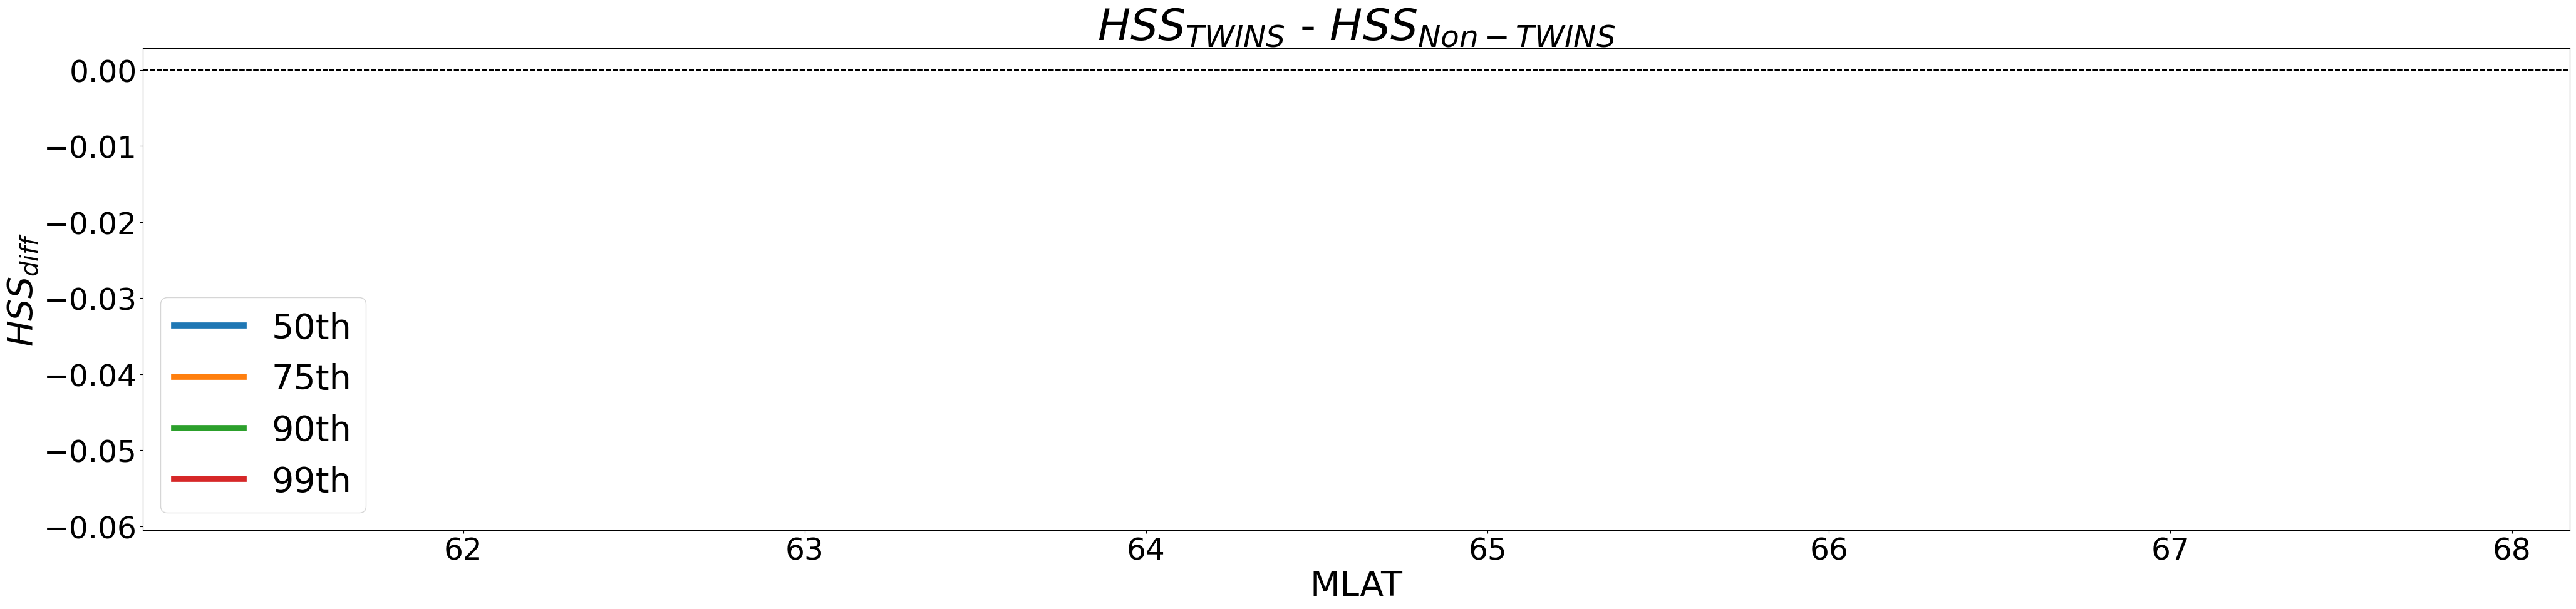

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(50, 10))

legends = ['50th', '75th', '90th', '99th']
for lege, thresh in zip(legends, thresholds):
	plotting_df = pd.DataFrame({'HSS_SS':[results_dict[region]['HSS_SS']['HSS_SS'].loc[thresh] for region in results_dict.keys()],
		 						'mlat':[results_dict[region]['mlat'] for region in results_dict.keys()]})
	plotting_df = plotting_df.sort_values(by='mlat')
	axes.plot(plotting_df['mlat'], plotting_df['HSS_SS'], label=lege, linewidth=7)
	axes.axhline(0, color='black', linestyle='--')

	# increasing size of the legend


axes.tick_params(axis='both', which='major', labelsize=35)
axes.set_xlabel('MLAT', fontsize=40)
axes.set_ylabel(r'$HSS_{diff}$', fontsize=40)
axes.set_title(r'$HSS_{TWINS}$ - $HSS_{Non-TWINS}$', fontsize=50)
plt.legend(fontsize=40)
# plt.tight_layout()
if not os.path.exists('plots/agu_presentation_plots'):
	os.makedirs('plots/agu_presentation_plots')
plt.savefig('plots/agu_presentation_plots/HSS_SS.png')

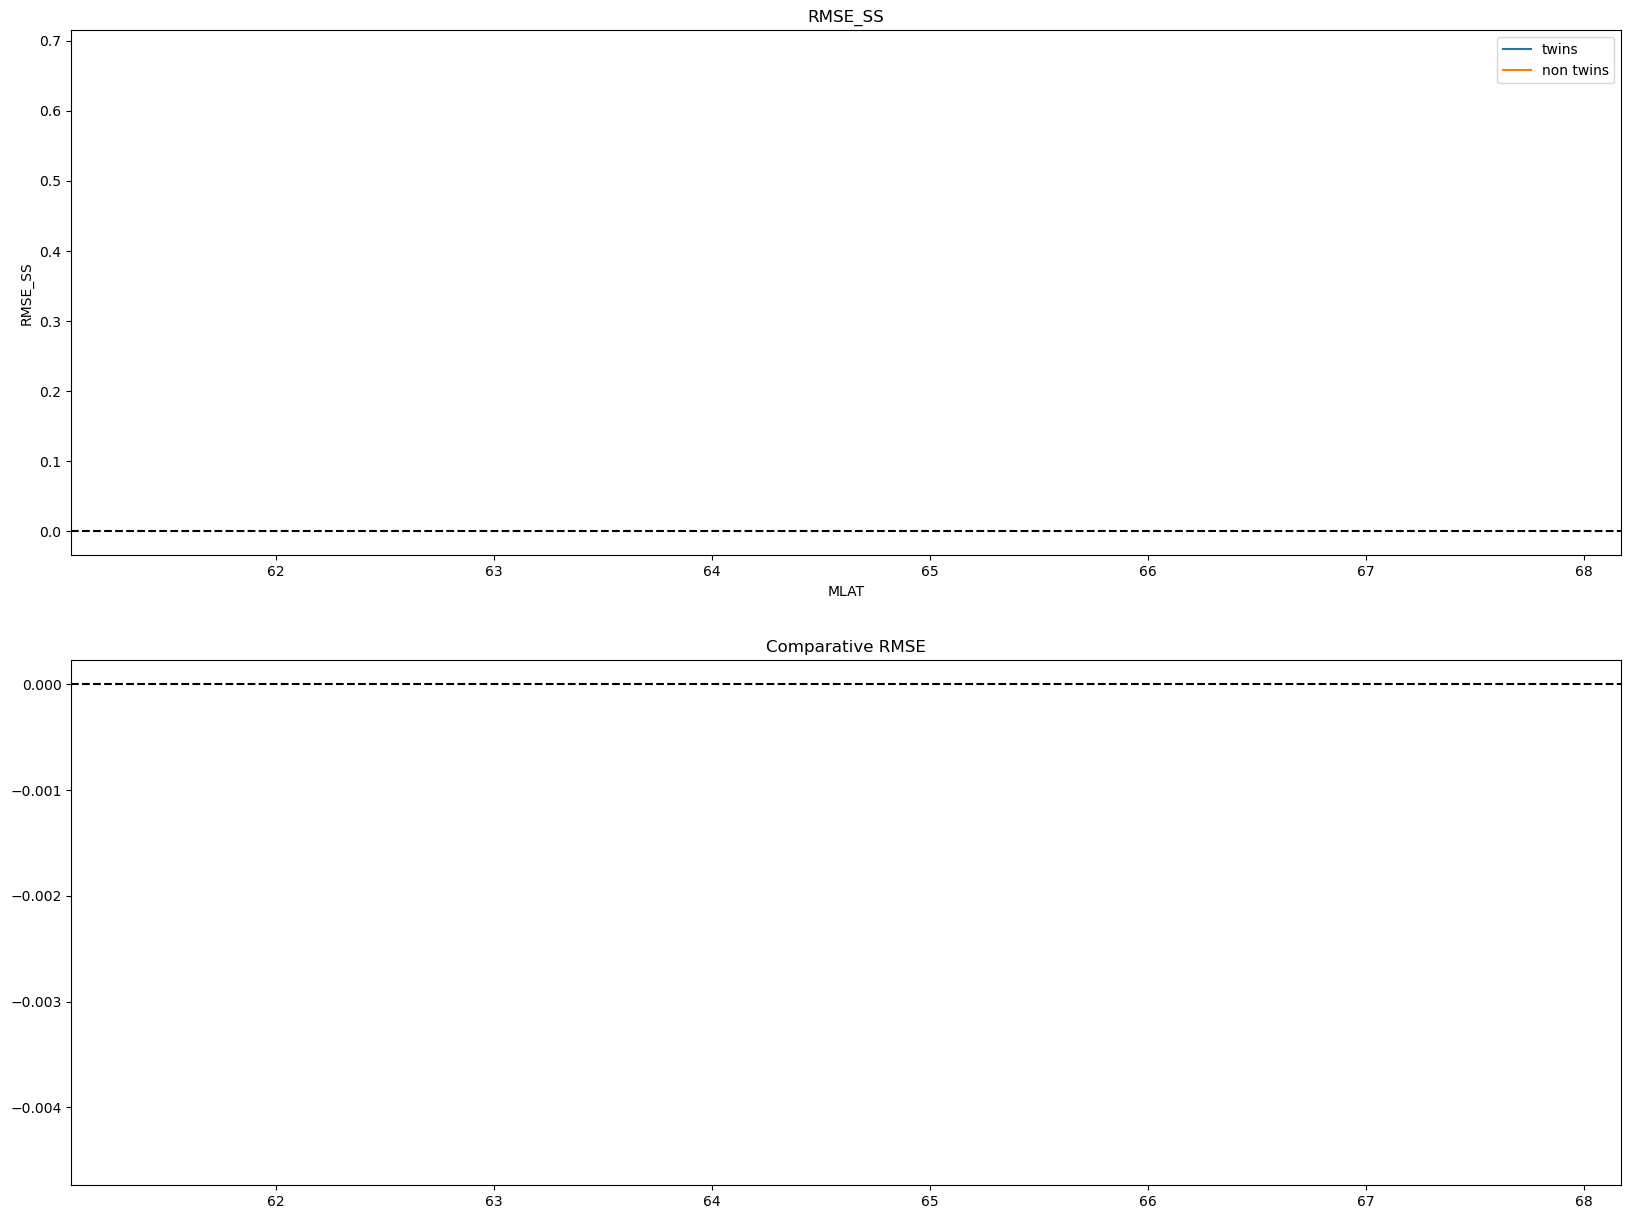

In [ ]:
rmse_ss_df = pd.DataFrame({'twins':[results_dict[region]['RMSE_SS']['twins'].loc[0] for region in results_dict.keys()],
							'non_twins':[results_dict[region]['RMSE_SS']['non_twins'].loc[0] for region in results_dict.keys()],
							'mlat':[results_dict[region]['mlat'] for region in results_dict.keys()]}).sort_values(by='mlat')

comaprative_rmse = pd.DataFrame({'comparative_rmse':[results_dict[region]['comparative_RMSE']['comparative_RMSE'].loc[0] for region in results_dict.keys()],
								'mlat':[results_dict[region]['mlat'] for region in results_dict.keys()]}).sort_values(by='mlat')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
axes[0].set_title('RMSE_SS')
axes[0].plot(rmse_ss_df['mlat'], rmse_ss_df['twins'], label='twins')
axes[0].plot(rmse_ss_df['mlat'], rmse_ss_df['non_twins'], label='non twins')
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].legend()
axes[0].set_xlabel('MLAT')
axes[0].set_ylabel('RMSE_SS')

axes[1].set_title('Comparative RMSE')
axes[1].plot(comaprative_rmse['mlat'], comaprative_rmse['comparative_rmse'])
axes[1].axhline(y=0, color='k', linestyle='--')

plt.show()

In [ ]:
twins_total_df, non_twins_total_df = pd.DataFrame(), pd.DataFrame()
for region in results_dict.keys():

	twins_temp_df = results_dict[region]['twins_results'].copy()
	non_twins_temp_df = results_dict[region]['non_twins_results'].copy()

	twins_temp_df.set_index('dates', inplace=True)
	non_twins_temp_df.set_index('dates', inplace=True)

	twins_combined = twins_temp_df.join(results_dict[region]['max_rsd'][['MLT', 'max_rsd_station']], how='left')
	non_twins_combined = non_twins_temp_df.join(results_dict[region]['max_rsd'][['MLT', 'max_rsd_station']], how='left')

	twins_combined['MLT'] = twins_combined['MLT'].astype(int)
	twins_combined['mlat'] = results_dict[region]['mlat'].astype(int)
	twins_combined.loc[twins_combined['MLT']==24, 'MLT'] = 0
	twins_total_df = pd.concat([twins_total_df, twins_combined], axis=0, ignore_index=True)

	non_twins_combined['MLT'] = non_twins_combined['MLT'].astype(int)
	non_twins_combined['mlat'] = results_dict[region]['mlat'].astype(int)
	non_twins_combined.loc[non_twins_combined['MLT']==24, 'MLT'] = 0
	non_twins_total_df = pd.concat([non_twins_total_df, non_twins_combined], axis=0, ignore_index=True)

twins_grouped_diff = twins_total_df.groupby(['MLT', 'mlat'])['error'].agg(['mean', 'median', 'std', 'count'])
non_twins_grouped_diff = non_twins_total_df.groupby(['MLT', 'mlat'])['error'].agg(['mean', 'median', 'std', 'count'])

twins_grouped_std = twins_total_df.groupby(['MLT', 'mlat'])['predicted_std'].agg(['mean', 'median', 'std', 'count'])
non_twins_grouped_std = non_twins_total_df.groupby(['MLT', 'mlat'])['predicted_std'].agg(['mean', 'median', 'std', 'count'])

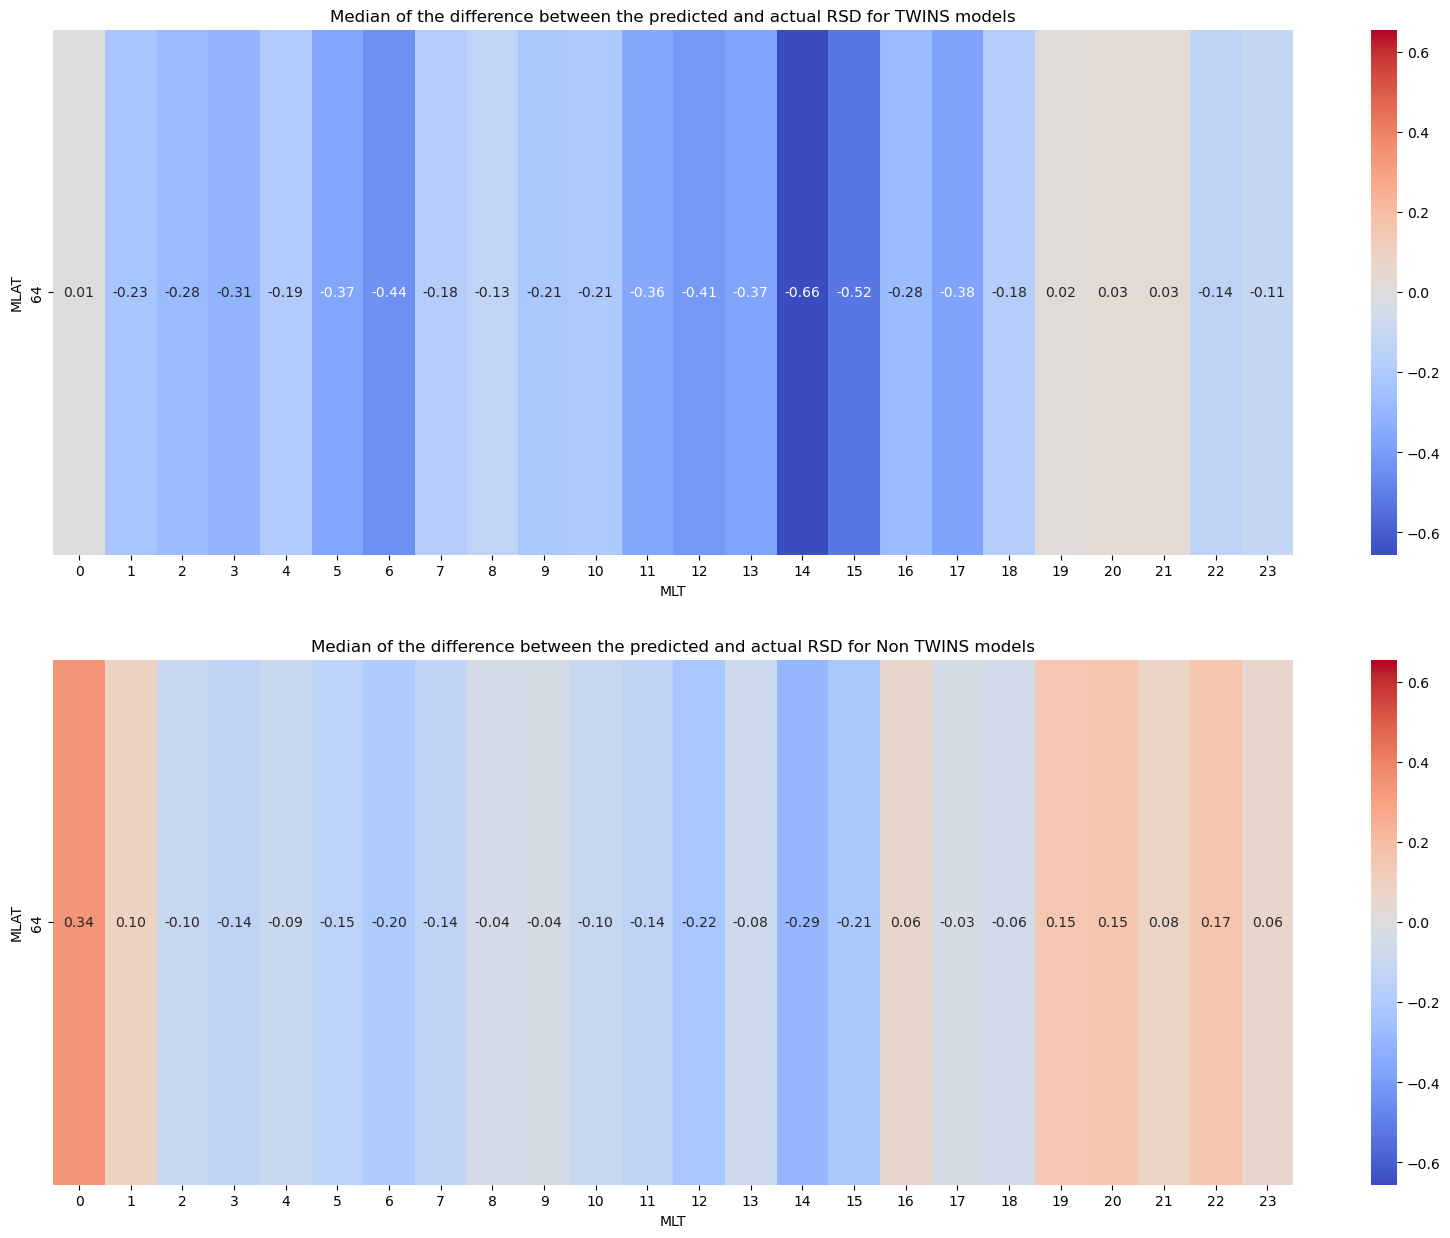

In [ ]:
# transfering the grouped dataframe to a pivot table
twins_pivot_median = twins_grouped_diff.pivot_table(index='MLT', columns='mlat', values='median')
twins_pivot_std = twins_grouped_diff.pivot_table(index='MLT', columns='mlat', values='std')
twins_pivot_mean = twins_grouped_diff.pivot_table(index='MLT', columns='mlat', values='mean')

# transfering the grouped dataframe to a pivot table
non_twins_pivot_median = non_twins_grouped_diff.pivot_table(index='MLT', columns='mlat', values='median')
non_twins_pivot_std = non_twins_grouped_diff.pivot_table(index='MLT', columns='mlat', values='std')
non_twins_pivot_mean = non_twins_grouped_diff.pivot_table(index='MLT', columns='mlat', values='mean')

plot_max = max(twins_pivot_median.abs().max().max(), non_twins_pivot_median.abs().max().max())

# plotting the pivot table with mlat on the y-axis in decending order and the MLT on the x-axis in ascending order
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
axes[0] = sns.heatmap(twins_pivot_median.T, ax=axes[0], cmap='coolwarm', vmin=-plot_max, vmax=plot_max, annot=True, fmt='.2f')
axes[0].invert_yaxis()
axes[0].set_ylabel('MLAT')
axes[0].set_title('Median of the difference between the predicted and actual RSD for TWINS models')
axes[1] = sns.heatmap(non_twins_pivot_median.T, ax=axes[1], cmap='coolwarm', vmin=-plot_max, vmax=plot_max, annot=True, fmt='.2f')
axes[1].invert_yaxis()
axes[1].set_ylabel('MLAT')
axes[1].set_xlabel('MLT')
axes[1].set_title('Median of the difference between the predicted and actual RSD for Non TWINS models')
plt.show()


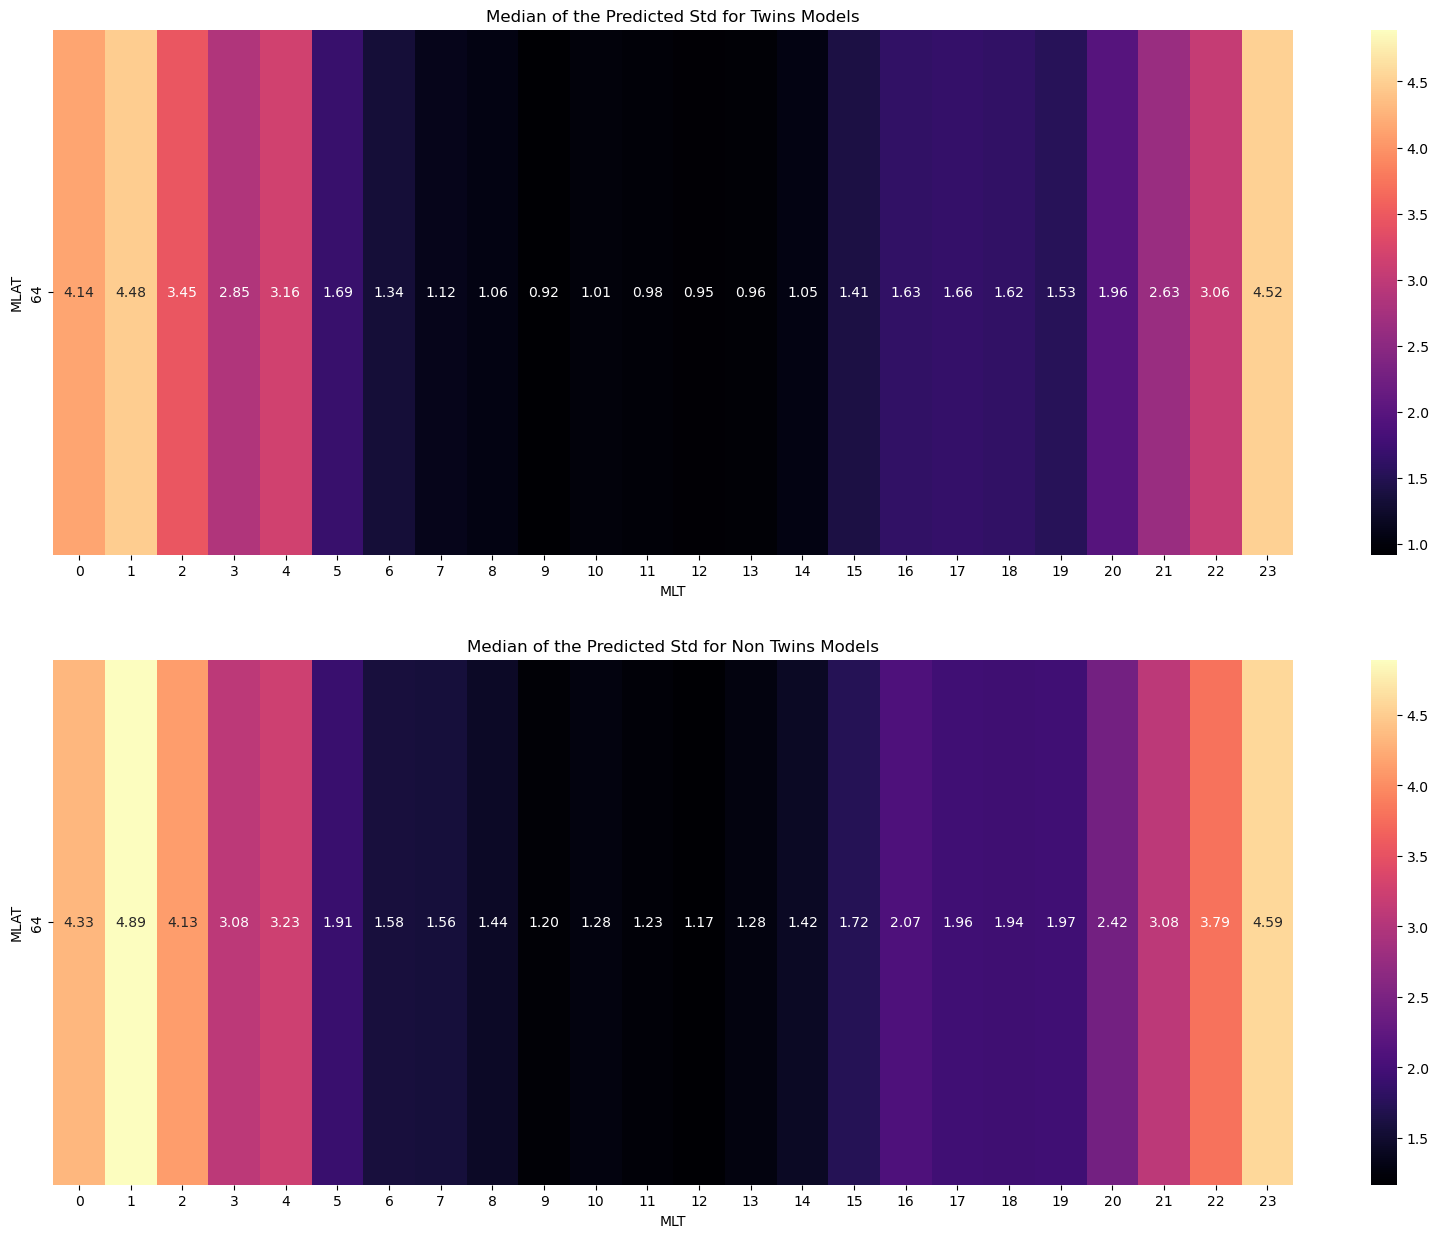

In [ ]:
# transfering the grouped dataframe to a pivot table
twins_pivot_median = twins_grouped_std.pivot_table(index="MLT", columns="mlat", values="median")
twins_pivot_mean = twins_grouped_std.pivot_table(index="MLT", columns="mlat", values="mean")
twins_pivot_std = twins_grouped_std.pivot_table(index="MLT", columns="mlat", values="std")

# transfering the grouped dataframe to a pivot table
non_twins_pivot_median = non_twins_grouped_std.pivot_table(index="MLT", columns="mlat", values="median")
non_twins_pivot_mean = non_twins_grouped_std.pivot_table(index="MLT", columns="mlat", values="mean")
non_twins_pivot_std = non_twins_grouped_std.pivot_table(index="MLT", columns="mlat", values="std")

vmax = max(twins_pivot_median.max().max(), non_twins_pivot_median.max().max())
# plotting the pivot table with mlat on the y-axis in decending order and the MLT on the x-axis in ascending order
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
axes[0] = sns.heatmap(twins_pivot_median.T, ax=axes[0], cmap='magma', vmax=vmax, annot=True, fmt='.2f')
axes[0].invert_yaxis()
axes[0].set_ylabel('MLAT')
axes[0].set_title('Median of the Predicted Std for Twins Models')
axes[1] = sns.heatmap(non_twins_pivot_median.T, ax=axes[1], cmap='magma', vmax=vmax, annot=True, fmt='.2f')
axes[1].invert_yaxis()
axes[1].set_ylabel('MLAT')
axes[1].set_xlabel('MLT')
axes[1].set_title('Median of the Predicted Std for Non Twins Models')
plt.show()

In [ ]:
non_twins_shap = {}

for region in results_dict.keys():
	if os.path.exists(f'outputs/shap_values/non_twins_region_{region}_evaluation_dict.pkl'):

		non_twins_shap[region] = {}

		with open(f'outputs/shap_values/non_twins_region_{region}_evaluation_dict.pkl', 'rb') as f:
			reg = pickle.load(f)
			non_twins_shap[region]['shap_dict'] = reg['2012-03-07']
	else:
		continue

	if os.path.exists(f'models/rsd/non_twins_region_{region}_version_final_2_scaler.pkl'):

		with open(f'models/rsd/non_twins_region_{region}_version_final_2_scaler.pkl', 'rb') as f:
			scaler = pickle.load(f)

		non_twins_shap[region]['shap_dict']['xtest'] = \
			np.array([scaler.inverse_transform(non_twins_shap[region]['shap_dict']['xtest'][i, :, :, 0]) \
				for i in range(non_twins_shap[region]['shap_dict']['xtest'].shape[0])])
	non_twins_shap[region]['mean'] = non_twins_shap[region]['shap_dict']['shap_values'][0][:,:,:,0]
	non_twins_shap[region]['std'] = non_twins_shap[region]['shap_dict']['shap_values'][1][:,:,:,0]

	# divide by the total to get the percentage

	non_twins_mean_totals = np.sum(np.sum(np.abs(non_twins_shap[region]['mean']), axis=1), axis=1)
	non_twins_std_totals = np.sum(np.sum(np.abs(non_twins_shap[region]['std']), axis=1), axis=1)

	for i in range(len(non_twins_mean_totals)):
		non_twins_shap[region]['mean'][i] = (non_twins_shap[region]['mean'][i] / non_twins_mean_totals[i]) * 100
		non_twins_shap[region]['std'][i] = (non_twins_shap[region]['std'][i] / non_twins_std_totals[i]) * 100

	# using the Date_UTC in the shap dict to get the MLT from the results dict
	mlt_df = pd.DataFrame({'Date_UTC':non_twins_shap[region]['shap_dict']['Date_UTC']})
	mlt_df.set_index('Date_UTC', inplace=True)
	temp_df = results_dict[region]['max_rsd']['MLT'].copy()
	non_twins_shap[region]['shap_dict']['mlt_df'] = mlt_df.join(temp_df, how='left')

	non_twins_shap[region]['mlat'] = results_dict[region]['mlat']

In [ ]:
twins_shap = {}

for region in REGIONS:
	if os.path.exists(f'outputs/shap_values/twins_region_{region}_evaluation_dict.pkl'):

		twins_shap[region] = {}

		with open(f'outputs/shap_values/twins_region_{region}_evaluation_dict.pkl', 'rb') as f:
			reg = pickle.load(f)
			twins_shap[region]['shap_dict'] = reg['2012-03-07']
	else:
		continue

	if os.path.exists(f'models/rsd/twins_region_{region}_version_final_scaler.pkl'):

		with open(f'models/rsd/twins_region_{region}_version_final_scaler.pkl', 'rb') as f:
			scaler = pickle.load(f)

		twins_shap[region]['shap_dict']['twins_test'] = \
			np.array([scaler['twins'].inverse_transform(twins_shap[region]['shap_dict']['twins_test'][i, :, :, 0]) \
				for i in range(twins_shap[region]['shap_dict']['twins_test'].shape[0])])

		twins_shap[region]['shap_dict']['xtest'] = \
			np.array([scaler['mag_and_solarwind'].inverse_transform(twins_shap[region]['shap_dict']['xtest'][i, :, :, 0]) \
				for i in range(twins_shap[region]['shap_dict']['xtest'].shape[0])])

	twins_shap[region]['twins_mean'] = np.vstack([twins_shap[region]['shap_dict']['shap_values'][i][0][1][:,:,:,0] \
		for i in range(len(twins_shap[region]['shap_dict']['shap_values']))])
	twins_shap[region]['twins_std'] = np.vstack([twins_shap[region]['shap_dict']['shap_values'][i][1][1][:,:,:,0] \
		for i in range(len(twins_shap[region]['shap_dict']['shap_values']))])

	twins_shap[region]['sw_mean'] = np.vstack([twins_shap[region]['shap_dict']['shap_values'][i][0][0][:,:,:,0] \
		for i in range(len(twins_shap[region]['shap_dict']['shap_values']))])
	twins_shap[region]['sw_std'] = np.vstack([twins_shap[region]['shap_dict']['shap_values'][i][1][0][:,:,:,0] \
		for i in range(len(twins_shap[region]['shap_dict']['shap_values']))])

	# divide by the total to get the percentage

	twins_mean_totals = np.sum(np.sum(np.abs(twins_shap[region]['twins_mean']), axis=1), axis=1)
	twins_std_totals = np.sum(np.sum(np.abs(twins_shap[region]['twins_std']), axis=1), axis=1)
	sw_mean_totals = np.sum(np.sum(np.abs(twins_shap[region]['sw_mean']), axis=1), axis=1)
	sw_std_totals = np.sum(np.sum(np.abs(twins_shap[region]['sw_std']), axis=1), axis=1)
	mean_totals = twins_mean_totals + sw_mean_totals
	std_totals = twins_std_totals + sw_std_totals

	for i in range(len(mean_totals)):
		twins_shap[region]['twins_mean'][i] = (twins_shap[region]['twins_mean'][i] / mean_totals[i]) * 100
		twins_shap[region]['twins_std'][i] = (twins_shap[region]['twins_std'][i] / std_totals[i]) * 100
		twins_shap[region]['sw_mean'][i] = (twins_shap[region]['sw_mean'][i] / mean_totals[i]) * 100
		twins_shap[region]['sw_std'][i] = (twins_shap[region]['sw_std'][i] / std_totals[i]) * 100

	# using the Date_UTC in the shap dict to get the MLT from the results dict
	mlt_df = pd.DataFrame({'Date_UTC':twins_shap[region]['shap_dict']['Date_UTC']})
	mlt_df.set_index('Date_UTC', inplace=True)
	temp_df = results_dict[region]['max_rsd']['MLT'].copy()
	twins_shap[region]['shap_dict']['mlt_df'] = mlt_df.join(temp_df, how='left')

	twins_shap[region]['mlat'] = results_dict[region]['mlat']

KeyError: 19

In [ ]:
plot_type = 'hist'
# selecting feature
feature = 'BZ_GSM'

# getting feature index
feature_index = features.index(feature)

# creating arrays of the shap values and the input values for the feature
non_twins_mean_shap_values, non_twins_std_shap_values, non_twins_xtest_values = [], [], []
twins_mean_shap_values, twins_std_shap_values, twins_xtest_values = [], [], []

for region in twins_shap.keys():
	for i in range(non_twins_shap[region]['shap_dict']['xtest'].shape[0]):
		non_twins_mean_shap_values.append(non_twins_shap[region]['mean'][i, :, feature_index])
		non_twins_std_shap_values.append(non_twins_shap[region]['std'][i, :, feature_index])
		non_twins_xtest_values.append(non_twins_shap[region]['shap_dict']['xtest'][i, :, feature_index])
	for i in range(twins_shap[region]['shap_dict']['xtest'].shape[0]):
		twins_mean_shap_values.append(twins_shap[region]['sw_mean'][i, :, feature_index])
		twins_std_shap_values.append(twins_shap[region]['sw_std'][i, :, feature_index])
		twins_xtest_values.append(twins_shap[region]['shap_dict']['xtest'][i, :, feature_index])

non_twins_mean_shap_values = np.array(non_twins_mean_shap_values)
non_twins_std_shap_values = np.array(non_twins_std_shap_values)
non_twins_xtest_values = np.array(non_twins_xtest_values)
twins_mean_shap_values = np.array(twins_mean_shap_values)
twins_std_shap_values = np.array(twins_std_shap_values)
twins_xtest_values = np.array(twins_xtest_values)

# plotting a 2d histogram of the shap values vs the input values
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 7))
axes[0,0].set_title(f'Non Twins Shap Values for Mean vs {feature} Values')
axes[0,0].set_ylabel('Shap Values')
if plot_type == 'scatter':
	axes[0,0].scatter(non_twins_xtest_values.flatten(), non_twins_mean_shap_values.flatten(), s=1)
	axes[0,0].axhline(y=0, color='k', linestyle='--')
elif plot_type == 'hist':
	axes[0,0].hist2d(non_twins_xtest_values.flatten(), non_twins_mean_shap_values.flatten(), bins=50, cmap='magma', norm=mpl.colors.LogNorm())
	axes[0,0].axhline(y=0, color='w', linestyle='--')
else:
	raise ValueError(f'plot_type must be either scatter or hist, not {plot_type}')

axes[0,1].set_title(f'Twins Shap Values for Mean vs {feature} Values')
axes[0,1].set_ylabel('Shap Values')
if plot_type == 'scatter':
	axes[0,1].scatter(twins_xtest_values.flatten(), twins_mean_shap_values.flatten(), s=1)
	axes[0,1].axhline(y=0, color='k', linestyle='--')
elif plot_type == 'hist':
	axes[0,1].hist2d(twins_xtest_values.flatten(), twins_mean_shap_values.flatten(), bins=50, cmap='magma', norm=mpl.colors.LogNorm())
	axes[0,1].axhline(y=0, color='w', linestyle='--')
else:
	raise ValueError(f'plot_type must be either scatter or hist, not {plot_type}')

axes[1,0].set_title(f'Non Twins Shap Values for std vs {feature} Values')
axes[1,0].set_xlabel(feature)
axes[1,0].set_ylabel('Shap Values')
if plot_type == 'scatter':
	axes[1,0].scatter(non_twins_xtest_values.flatten(), non_twins_std_shap_values.flatten(), s=1)
	axes[1,0].axhline(y=0, color='k', linestyle='--')
elif plot_type == 'hist':
	axes[1,0].hist2d(non_twins_xtest_values.flatten(), non_twins_std_shap_values.flatten(), bins=50, cmap='magma', norm=mpl.colors.LogNorm())
	axes[1,0].axhline(y=0, color='w', linestyle='--')
else:
	raise ValueError(f'plot_type must be either scatter or hist, not {plot_type}')

axes[1,1].set_title(f'Twins Shap Values for std vs {feature} Values')
axes[1,1].set_xlabel(feature)
axes[1,1].set_ylabel('Shap Values')
if plot_type == 'scatter':
	axes[1,1].scatter(twins_xtest_values.flatten(), twins_std_shap_values.flatten(), s=1)
	axes[1,1].axhline(y=0, color='k', linestyle='--')
elif plot_type == 'hist':
	axes[1,1].hist2d(twins_xtest_values.flatten(), twins_std_shap_values.flatten(), bins=50, cmap='magma', norm=mpl.colors.LogNorm())
	axes[1,1].axhline(y=0, color='w', linestyle='--')
else:
	raise ValueError(f'plot_type must be either scatter or hist, not {plot_type}')
plt.show()


KeyError: 19

In [ ]:
twins_mean_influence, twins_std_influence, twins_error = [], [], []
non_twins_mean_influence, non_twins_std_influence, non_twins_error = [], [], []

twins_error_df, non_twins_error_df = pd.DataFrame(), pd.DataFrame()
twins_error_array, non_twins_error_array = [], []
for region in twins_shap.keys():
	twins_temp = pd.DataFrame({'Date_UTC':twins_shap[region]['shap_dict']['Date_UTC']})
	twins_temp.set_index('Date_UTC', inplace=True)
	non_twins_temp = pd.DataFrame({'Date_UTC':non_twins_shap[region]['shap_dict']['Date_UTC']})
	non_twins_temp.set_index('Date_UTC', inplace=True)
	if 'dates' in results_dict[region]['twins_results'].columns:
		results_dict[region]['twins_results'].set_index('dates', inplace=True)
	twins_temp = twins_temp.join(results_dict[region]['twins_results']['error'], how='left')
	if 'dates' in results_dict[region]['non_twins_results'].columns:
		results_dict[region]['non_twins_results'].set_index('dates', inplace=True)
	non_twins_temp = non_twins_temp.join(results_dict[region]['non_twins_results']['error'], how='left')
	twins_shap[region]['error'] = twins_temp
	non_twins_shap[region]['error'] = non_twins_temp
	twins_error_df[f'region_{region}'] = twins_temp['error']
	non_twins_error_df[f'region_{region}'] = non_twins_temp['error']
	twins_error_array.append(twins_temp['error'])
	non_twins_error_array.append(non_twins_temp['error'])


for region in twins_shap.keys():
	twins_mean_influence.append(np.sum(np.abs(twins_shap[region]['sw_mean']),axis=1))
	twins_std_influence.append(np.sum(np.abs(twins_shap[region]['sw_std']),axis=1))
	non_twins_mean_influence.append(np.sum(np.abs(non_twins_shap[region]['mean']),axis=1))
	non_twins_std_influence.append(np.sum(np.abs(non_twins_shap[region]['std']),axis=1))

twins_mean_influence = np.vstack(twins_mean_influence)
twins_std_influence = np.vstack(twins_std_influence)
non_twins_mean_influence = np.vstack(non_twins_mean_influence)
non_twins_std_influence = np.vstack(non_twins_std_influence)
twins_error_array = pd.concat(twins_error_array, axis=0)
non_twins_error_array = pd.concat(non_twins_error_array, axis=0)

print(twins_mean_influence.shape)
print(twins_std_influence.shape)
print(non_twins_mean_influence.shape)
print(non_twins_std_influence.shape)
print(twins_error_array.shape)
print(non_twins_error_array.shape)

KeyError: 19

TypeError: list indices must be integers or slices, not tuple

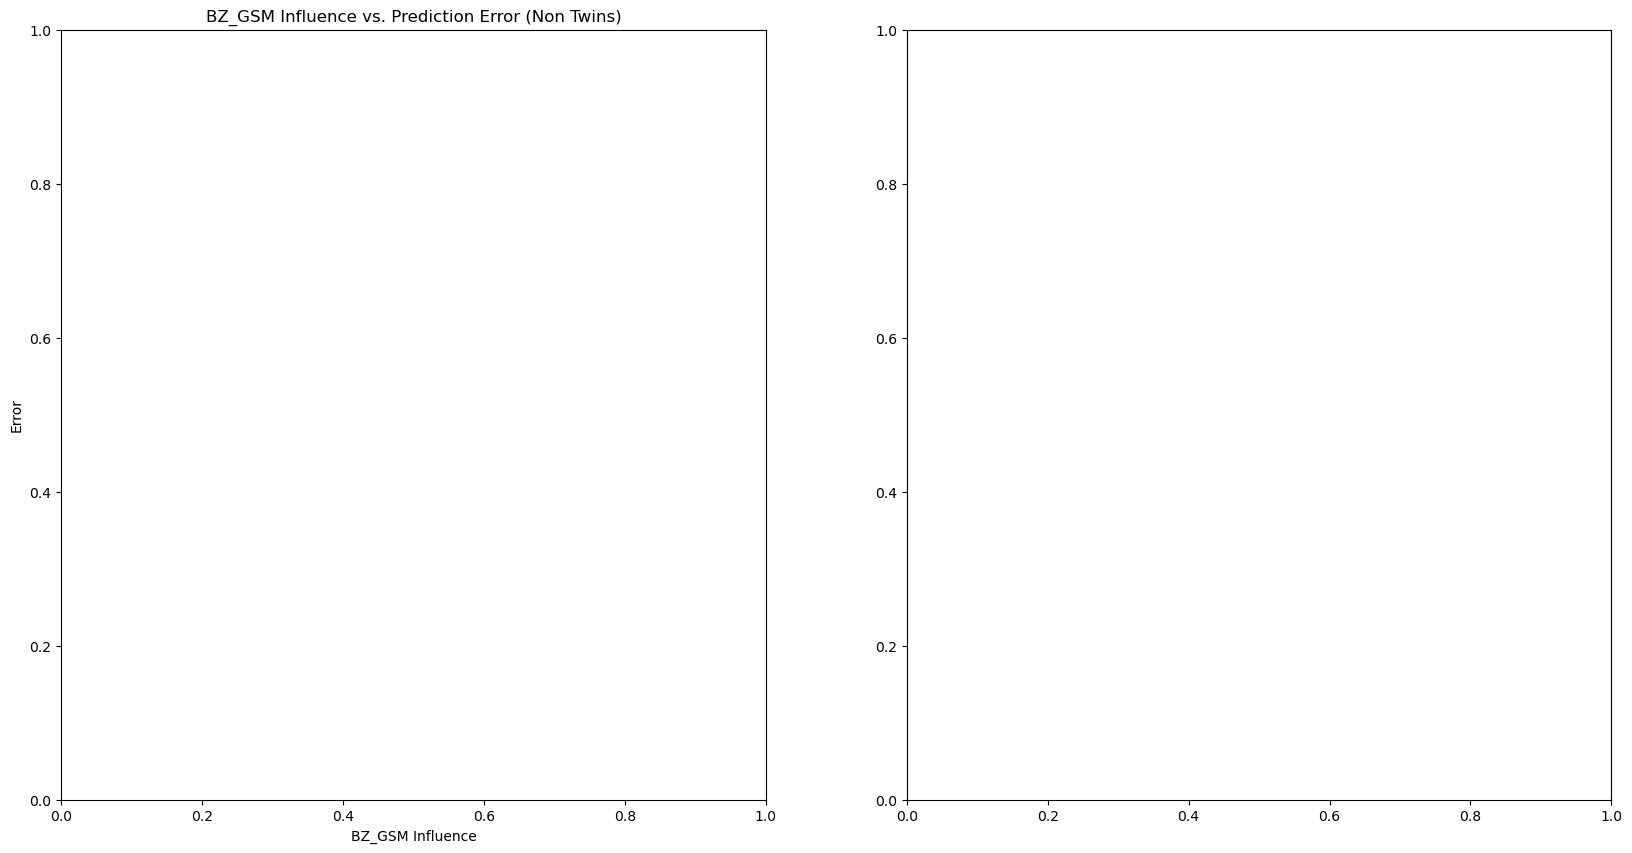

In [ ]:
plot_type = 'hist'
# selecting feature
feature = "BZ_GSM"

# getting feature index
feature_index = features.index(feature)

# plotting a 2d histogram of the shap values vs the input values
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].set_title(f'{feature} Influence vs. Prediction Error (Non Twins)')
axes[0].set_ylabel('Error')
axes[0].set_xlabel(f'{feature} Influence')
if plot_type == 'scatter':
	axes[0].scatter(non_twins_mean_influence[:,feature_index], non_twins_error_array, s=1)
	axes[0].axhline(y=0, color='k', linestyle='--')
elif plot_type == 'hist':
	axes[0].hist2d(non_twins_mean_influence[:,feature_index], non_twins_error_array, bins=50, cmap='magma', norm=mpl.colors.LogNorm())
	axes[0].axhline(y=0, color='w', linestyle='--')
else:
	raise ValueError(f'plot_type must be either scatter or hist, not {plot_type}')

axes[1].set_title(f'{feature} Influence vs. Prediction Error (Twins)')
axes[1].set_ylabel('Error')
axes[1].set_xlabel(f'{feature} Influence')
if plot_type == 'scatter':
	axes[1].scatter(twins_mean_influence[:,feature_index], twins_error_array, s=1)
	axes[1].axhline(y=0, color='k', linestyle='--')
elif plot_type == 'hist':
	axes[1].hist2d(twins_mean_influence[:,feature_index], twins_error_array, bins=50, cmap='magma', norm=mpl.colors.LogNorm())
	axes[1].axhline(y=0, color='w', linestyle='--')
else:
	raise ValueError(f'plot_type must be either scatter or hist, not {plot_type}')

(6255, 90, 60)


KeyError: 'error'

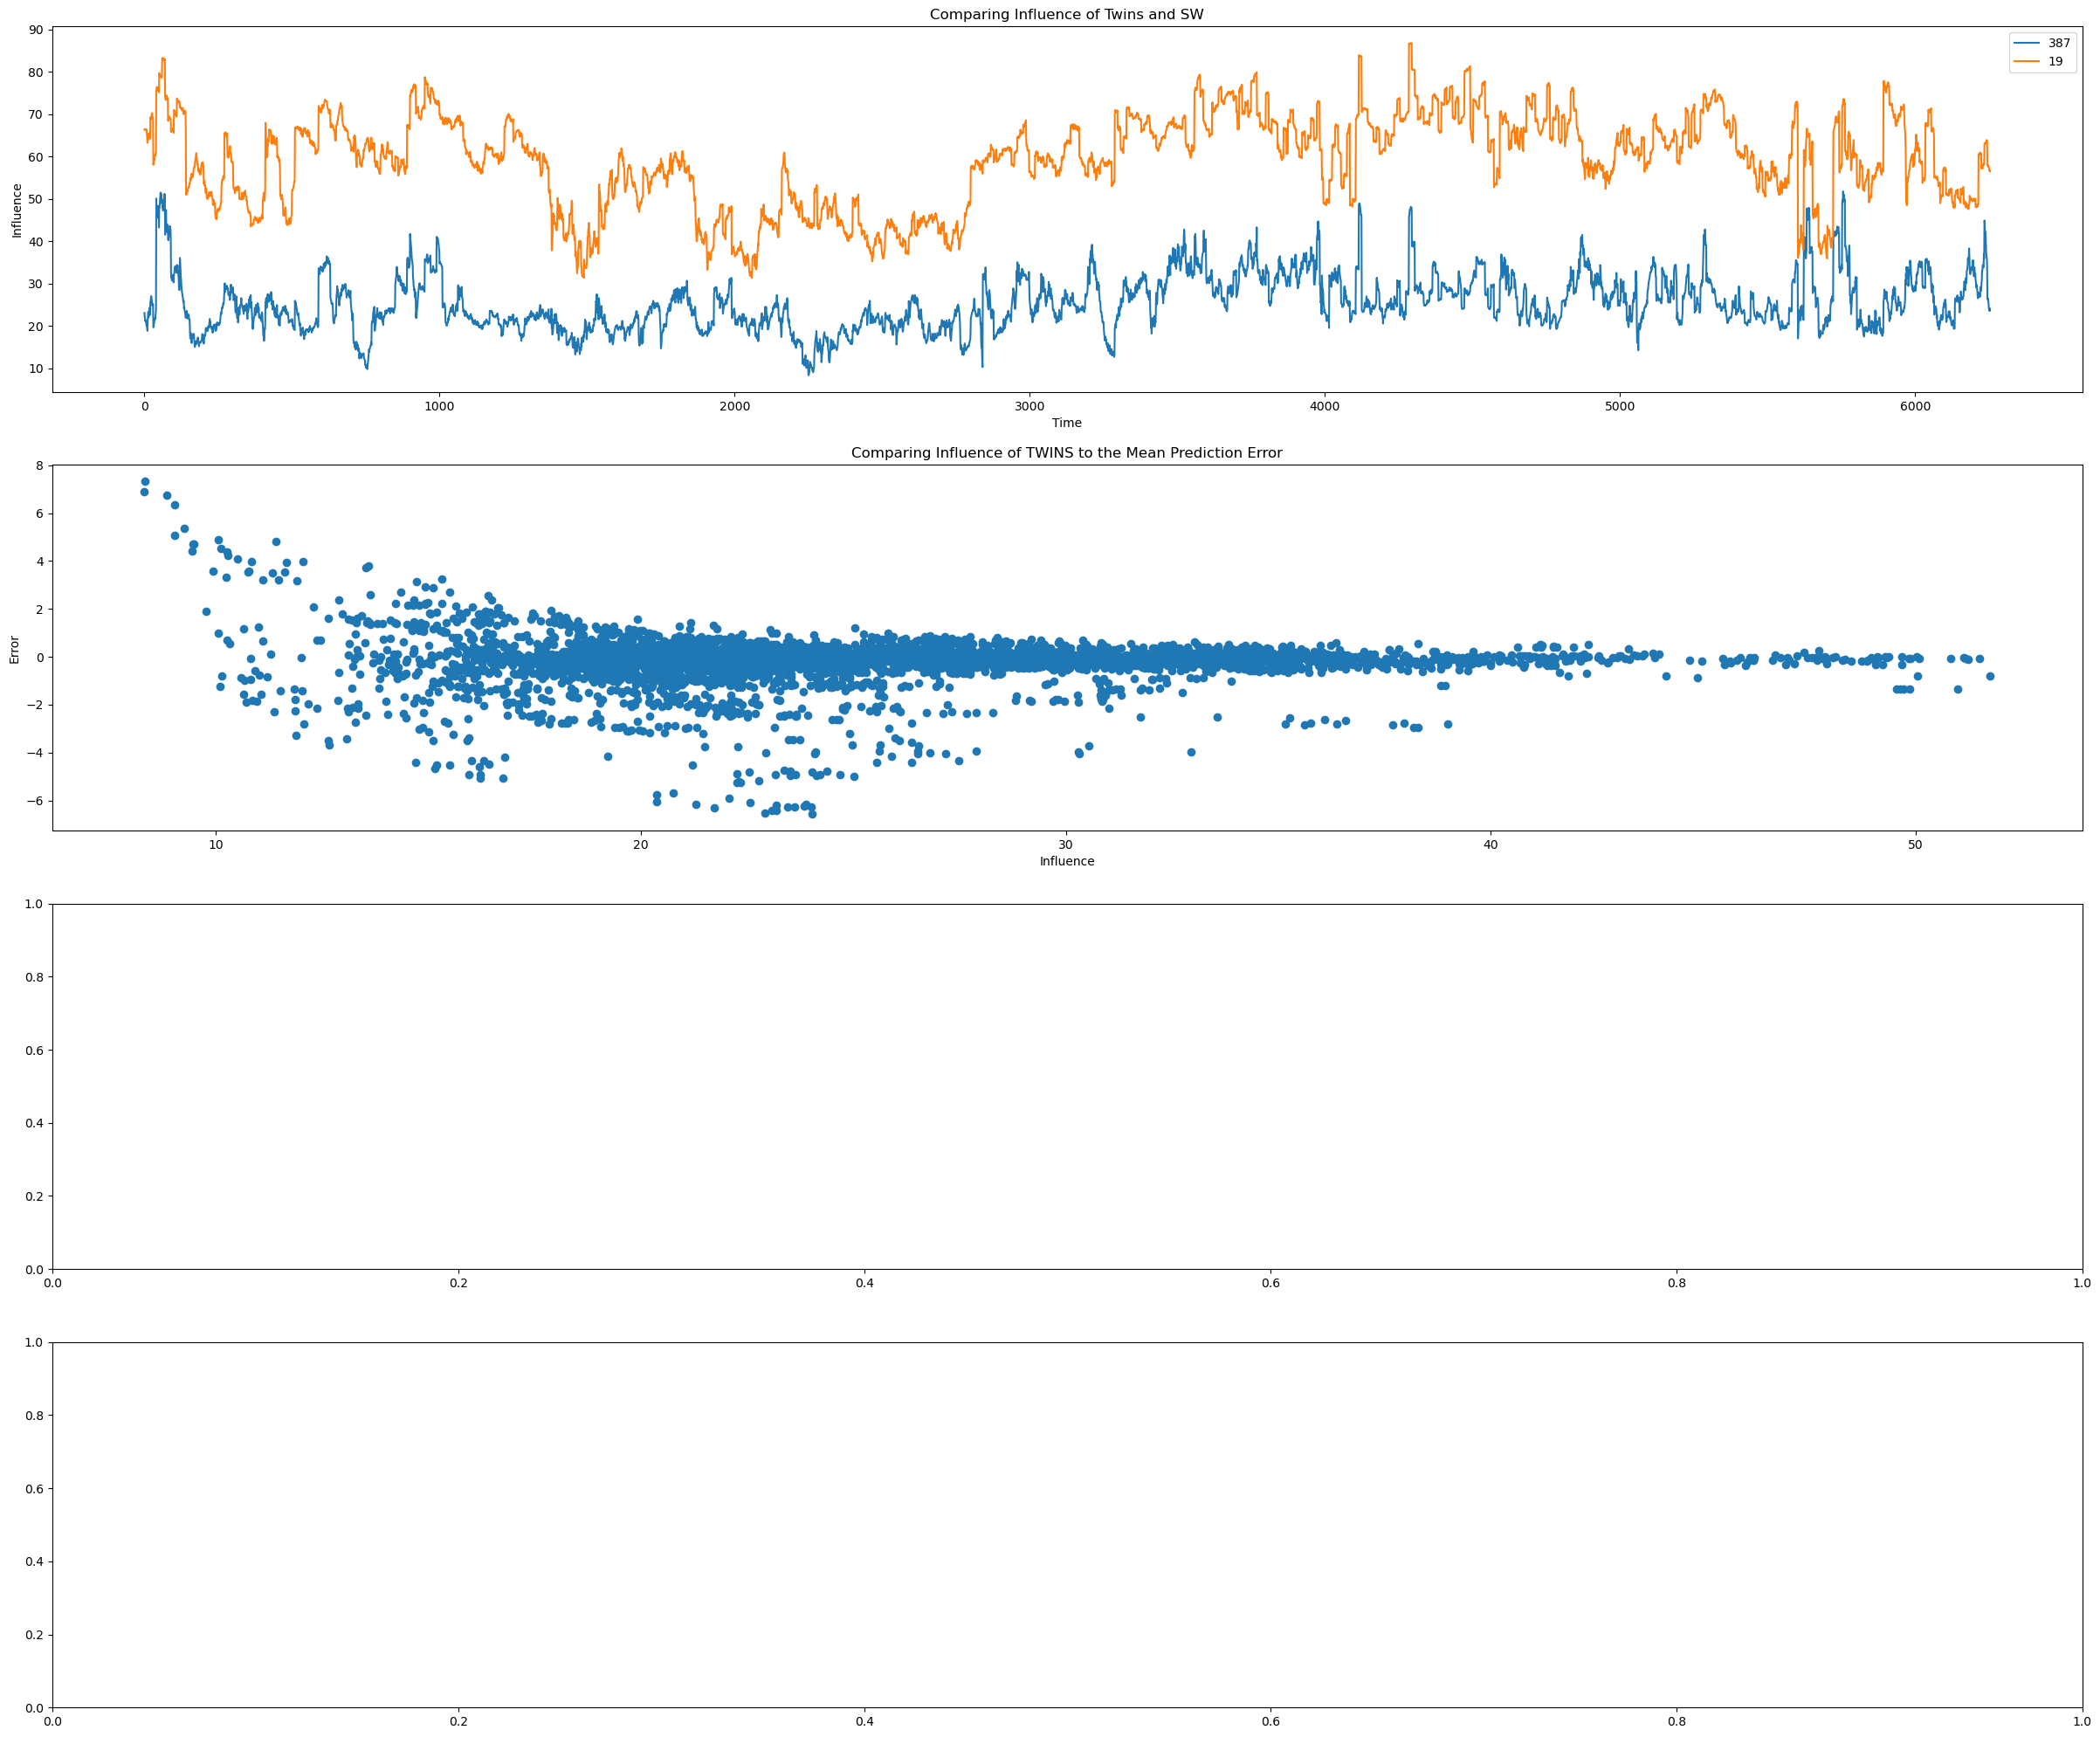

In [ ]:
twins_mean = twins_shap[387]['twins_mean']
print(twins_mean.shape)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 25))
axes[0].set_title('Comparing Influence of Twins and SW')
axes[0].set_ylabel('Influence')
axes[0].set_xlabel('Time')
for region in twins_shap.keys():
	axes[0].plot([np.sum(np.abs(twins_shap[region]['twins_mean'][i])) for i in range(twins_shap[region]['twins_mean'].shape[0])], label=region)
axes[0].legend()

axes[1].set_title('Comparing Influence of TWINS to the Mean Prediction Error')
axes[1].set_xlabel('Influence')
axes[1].set_ylabel('Error')
for region in twins_shap.keys():
	axes[1].scatter(np.sum(np.sum(np.abs(twins_shap[region]['twins_mean']),axis=1),axis=1), twins_shap[region]['error']/twins_shap[region]['shap_dict']['ytest'].mean(), label=region)
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_yscale('symlog')
axes[1].legend()

axes[2].set_title('Comparing Influence of TWINS to the Mean Temperature')
axes[2].set_ylabel('Influence')
axes[2].set_xlabel('Temperature')
for region in twins_shap.keys():
	axes[2].scatter([np.mean(twins_shap[region]['shap_dict']['twins_test'][i]) for i in range(twins_shap[region]['shap_dict']['twins_test'].shape[0])], [np.sum(np.abs(twins_shap[region]['twins_mean'][i])) for i in range(twins_shap[region]['twins_mean'].shape[0])], label=region)
axes[2].legend()

axes[3].set_title('Comparing Influence of TWINS to the Mean Temperature')
axes[3].set_ylabel('Influence')
axes[3].set_xlabel('MLT')
mlt = pd.DataFrame({'mlt':[], 'influence':[]})
for region in twins_shap.keys():
	temp_mlt = pd.DataFrame({'mlt':twins_shap[region]['shap_dict']['mlt_df']['MLT'],
							'influence':[np.sum(np.abs(twins_shap[region]['twins_mean'][i])) for i in range(twins_shap[region]['twins_mean'].shape[0])]})
	mlt_delimiter = pd.cut(temp_mlt['mlt'], bins=48, labels=np.arange(0, 48))
	temp_mlt = temp_mlt.groupby(mlt_delimiter)['influence'].mean()
	axes[3].plot(temp_mlt.index, temp_mlt.values, label=round(twins_shap[region]['mlat'], 2))
axes[3].set_xticks(np.arange(0, 48, 12))
axes[3].set_xticklabels(np.arange(0, 24, 6))
axes[3].legend()

plt.show()

KeyError: 'mlat'

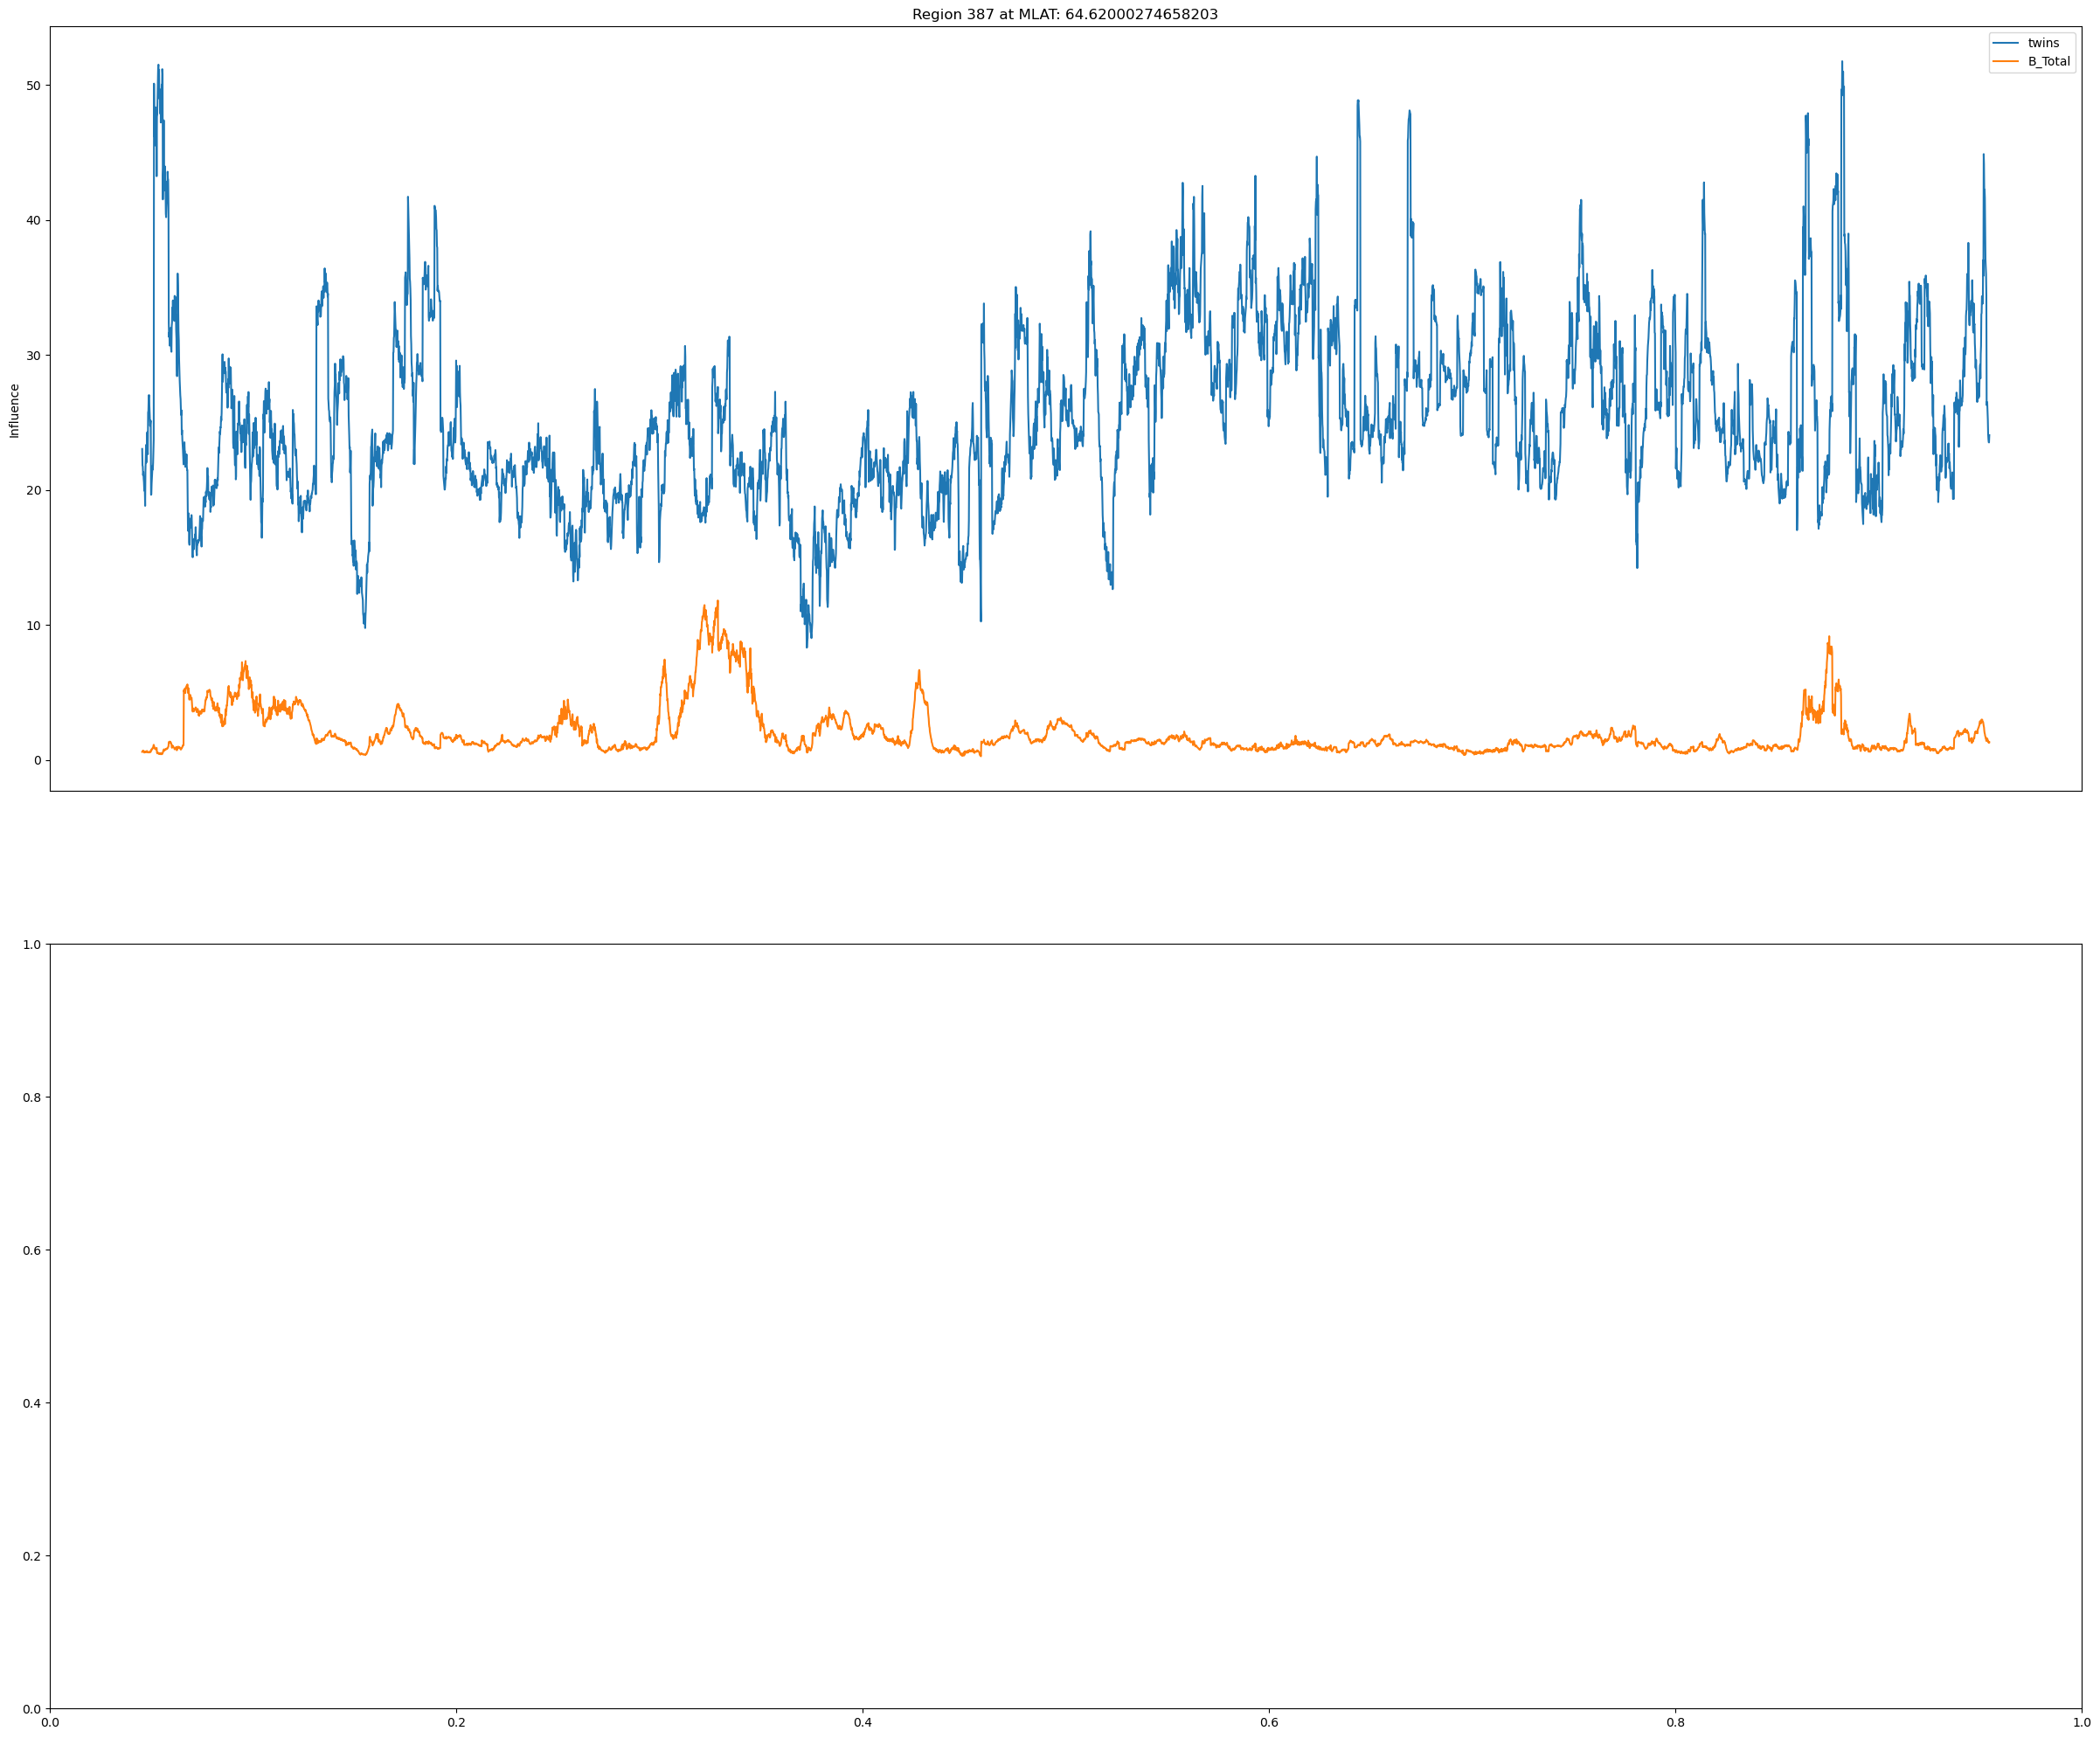

In [ ]:
feature_to_examine = 'B_Total'

fig, axes = plt.subplots(nrows=len(twins_shap.keys()), ncols=1, figsize=(30, 25))
for k, region in enumerate(twins_shap.keys()):
	axes[k].set_title(f'Region {region} at MLAT: {round(twins_shap[region]["mlat"], 2)}')
	axes[k].set_ylabel('Influence')
	axes[k].set_xticks([])
	axes[k].plot(np.sum(np.sum(np.abs(twins_shap[region]['twins_mean']),axis=1),axis=1), label='twins')
	axes[k].plot(np.sum(np.abs(twins_shap[region]['sw_mean']),axis=1)[:, features.index(feature_to_examine)], label=feature_to_examine)
	axes[k].legend()

plt.show()


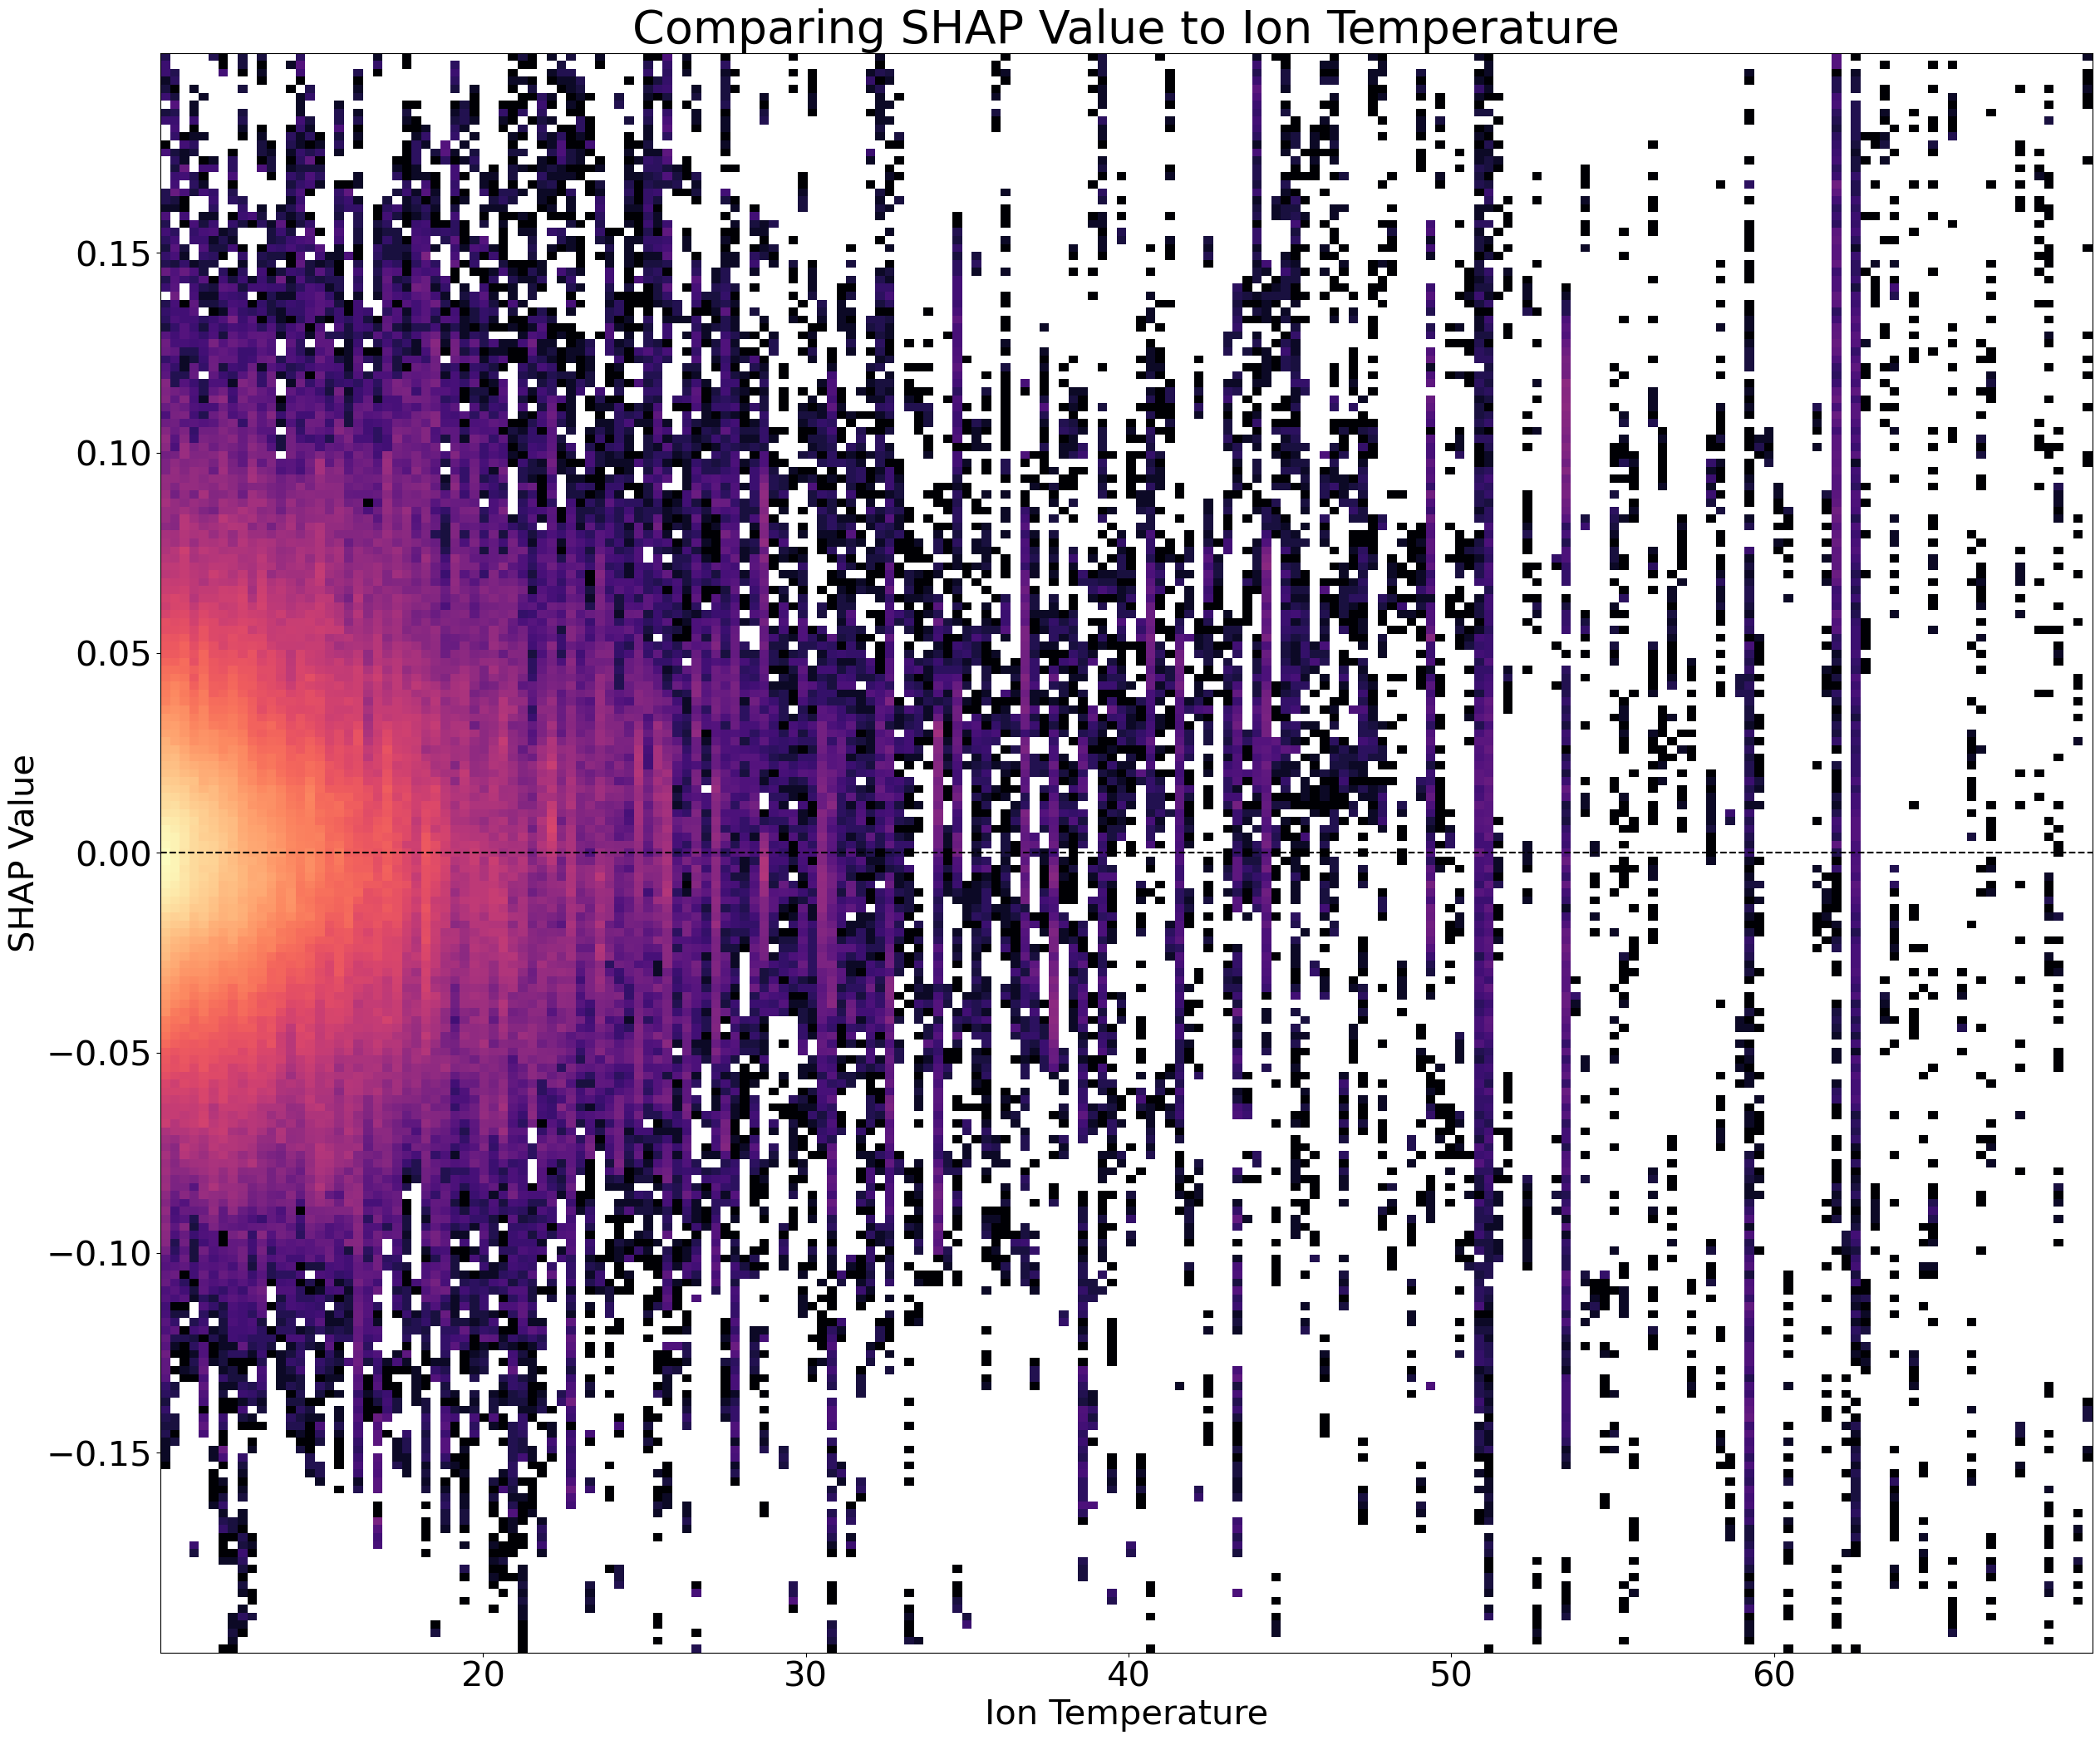

In [ ]:
fig, axes = plt.subplots(1, ncols=1, figsize=(30, 25), sharex=True)
axes.set_title("Comparing SHAP Value to Ion Temperature", fontsize=40)
# Creating empty arrays for concatenating the flattened arrays
temps, shaps = [], []
for k, region in enumerate(twins_shap.keys()):
    temps.append(twins_shap[region]["shap_dict"]["twins_test"].flatten())
    shaps.append(twins_shap[region]["twins_mean"].flatten())

temps = np.concatenate(temps)
shaps = np.concatenate(shaps)

neg_indicies = np.where(temps < 10)[0]
temps = np.delete(temps, neg_indicies)
shaps = np.delete(shaps, neg_indicies)

pos_shap_indicies = np.where(shaps > 0.2)[0]
temps = np.delete(temps, pos_shap_indicies)
shaps = np.delete(shaps, pos_shap_indicies)

neg_shap_indicies = np.where(shaps <= -0.2)[0]
temps = np.delete(temps, neg_shap_indicies)
shaps = np.delete(shaps, neg_shap_indicies)

im = axes.hist2d(temps, shaps, bins=[200, 201], cmap="magma", norm=mpl.colors.LogNorm())
axes.axhline(y=0, color="k", linestyle="--")
axes.set_xlabel("Ion Temperature", fontsize=30)
axes.set_ylabel("SHAP Value", fontsize=30)
axes.margins(x=0)
axes.tick_params(axis="both", which="major", labelsize=30)
plt.savefig("plots/agu_presentation_plots/SHAP_vs_Ion_Temperature.png")

dict_keys([387, 19])
Date of High Influence Map: 2012-03-07 15:50:00


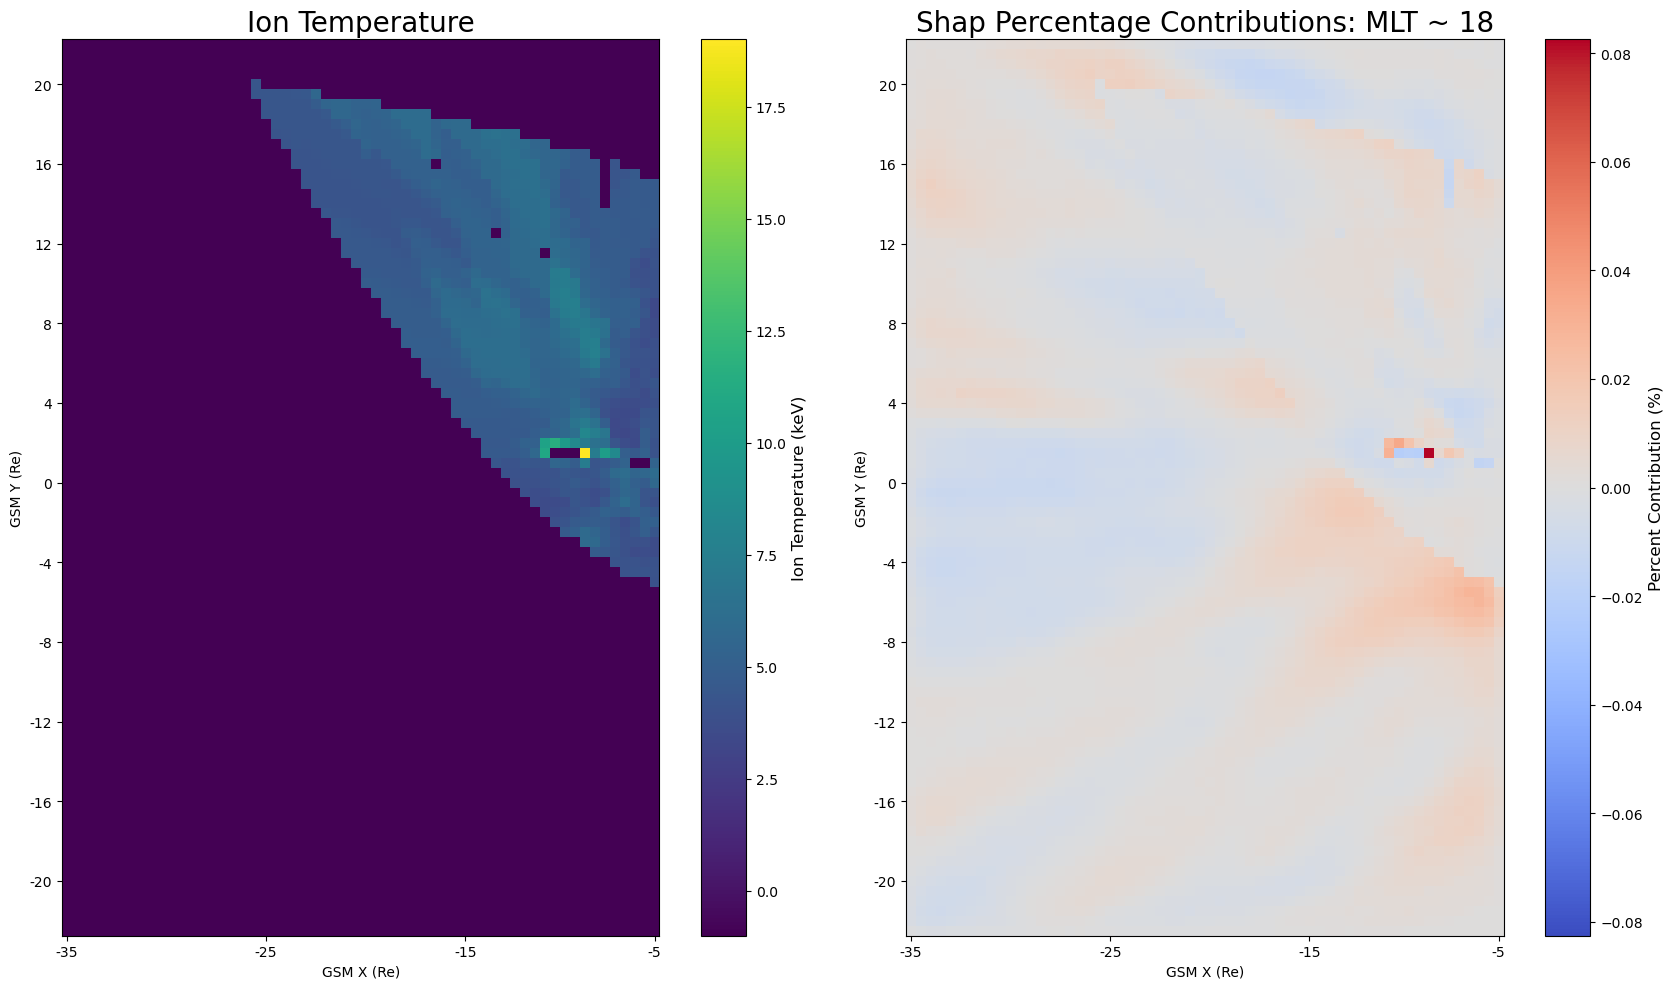

In [ ]:
high_twins_influence = {}
for region in twins_shap.keys():
	high_twins_influence[region] = np.where(np.sum(np.sum(np.abs(twins_shap[region]['twins_mean']), axis=1), axis=1) >= 50)[0]

x_ticks = np.arange(0, 60, 20)
x_ticks = np.hstack([x_ticks,59])
x_tick_labels = np.arange(-35, -4, 10)
y_ticks = np.arange(5, 86, 8)
y_tick_labels = np.arange(-20, 21, 4)

print(twins_shap.keys())
reg = 387

date_index = twins_shap[reg]['shap_dict']['Date_UTC'][twins_shap[reg]['shap_dict']['Date_UTC']=='2012-03-07 15:50:00'].index[0]

# finding the index corresponding to a date to use for getting the corresponding map

print(f"Date of High Influence Map: {twins_shap[reg]['shap_dict']['Date_UTC'][date_index]}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].set_title(f"Ion Temperature", fontsize=20)
twins_im = axes[0].imshow(twins_shap[reg]['shap_dict']['twins_test'][date_index], origin='lower')
cbar = axes[0].figure.colorbar(twins_im, ax=axes[0])
cbar.set_label('Ion Temperature (keV)', fontsize=12)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_tick_labels)
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels(y_tick_labels)
axes[0].set_xlabel('GSM X (Re)')
axes[0].set_ylabel('GSM Y (Re)')

axes[1].set_title(f"Shap Percentage Contributions: MLT ~ {round(twins_shap[reg]['shap_dict']['mlt_df']['MLT'].values[date_index])}", fontsize=20)
max_shap = np.max(np.abs(twins_shap[reg]['twins_mean'][date_index]))
shap_im = axes[1].imshow(twins_shap[reg]['twins_mean'][date_index], origin='lower', cmap='coolwarm', vmin=-max_shap, vmax=max_shap)
cbar = axes[1].figure.colorbar(shap_im, ax=axes[1])
cbar.set_label('Percent Contribution (%)', fontsize=12)
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_tick_labels)
axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels(y_tick_labels)
axes[1].set_xlabel('GSM X (Re)')
axes[1].set_ylabel('GSM Y (Re)')
plt.tight_layout()
plt.subplots_adjust(left=0.15)
plt.savefig('plots/agu_presentation_plots/twins_shap_example.png')

In [ ]:
twins_shap.keys()

dict_keys([387, 19])

In [ ]:
model = load_model("models/autoencoder_v_final_0-5.h5")
# with open(f"models/rsd/twins_region_321_version_final_scaler.pkl", "rb") as f:
#     scaler = pickle.load(f)

twins_test = twins_shap[387]["shap_dict"]["twins_test"]
# twins_test = np.array([scaler["twins"].transform(twins_test[i, :, :]) for i in range(twins_test.shape[0])])
# twins_test = twins_test.reshape(twins_test.shape[0], twins_test.shape[1], twins_test.shape[2], 1)
predictions = model.predict(twins_test)
# predictions = np.array([scaler["twins"].inverse_transform(predictions[i, :, :, 0]) for i in range(predictions.shape[0])])

196/196 [==============================] - 103s 526ms/step


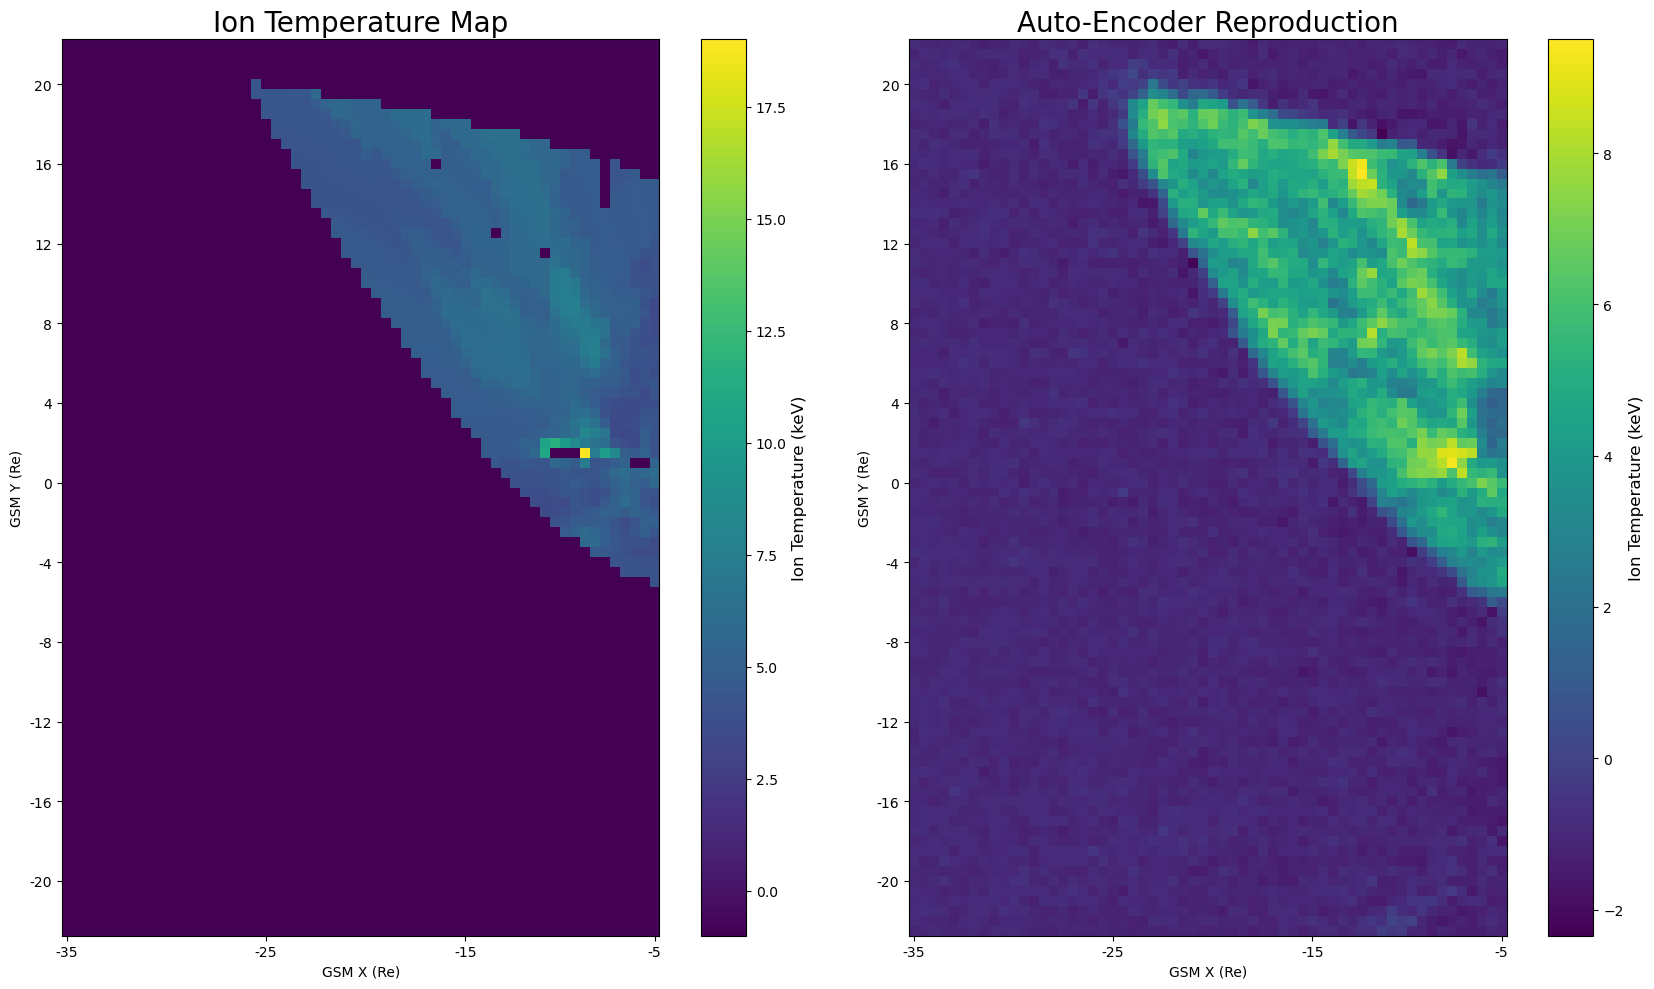

In [ ]:
HI_map = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].set_title(f"Ion Temperature Map", fontsize=20)
twins_im = axes[0].imshow(twins_shap[reg]['shap_dict']['twins_test'][date_index], origin='lower')
cbar = axes[0].figure.colorbar(twins_im, ax=axes[0])
cbar.set_label('Ion Temperature (keV)', fontsize=12)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_tick_labels)
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels(y_tick_labels)
axes[0].set_xlabel('GSM X (Re)')
axes[0].set_ylabel('GSM Y (Re)')

axes[1].set_title("Auto-Encoder Reproduction", fontsize=20)
auto_im = axes[1].imshow(predictions[date_index], origin='lower')
cbar = axes[1].figure.colorbar(auto_im, ax=axes[1])
cbar.set_label('Ion Temperature (keV)', fontsize=12)
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_tick_labels)
axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels(y_tick_labels)
axes[1].set_xlabel('GSM X (Re)')
axes[1].set_ylabel('GSM Y (Re)')

plt.tight_layout()
plt.subplots_adjust(left=0.15)
plt.savefig('plots/agu_presentation_plots/twins_autoencoder_example.png')


In [ ]:
def examining_distributions_in_parts_of_the_predictions(prediction, noise_dims, temp_dims):

	# defining the areas of the bounding boxes
	noise_left, noise_right, noise_top, noise_bottom = noise_dims
	temp_left, temp_right, temp_top, temp_bottom = temp_dims

	noise_box = prediction[noise_top:noise_bottom, noise_left:noise_right]
	temp_box = prediction[temp_top:temp_bottom, temp_left:temp_right]

	print(f'Noise Box: Mean: {noise_box.mean()}, Std: {noise_box.std()}')

	# plotting histograms of the areas of interest
	fig = plt.figure(figsize=(10, 10))
	ax1 = fig.add_subplot(111)
	plt.axvline(x=-1, color='k', linestyle='--')
	ax1.hist(noise_box.flatten(), bins=100, alpha=0.5, label='Noise', color='orange')
	ax1.hist(temp_box.flatten(), bins=100, alpha=0.5, label='Temperature', color='red')
	ax1.legend()
	plt.savefig('plots/agu_presentation_plots/histograms_of_noise_and_temp_distributions.png')

	# plotting the prediction including bounding boxes around the areas of interest.
	fig = plt.figure(figsize=(10, 10))
	ax1 = fig.add_subplot(111)
	ax1.imshow(prediction, vmin=prediction.min(), vmax=prediction.max(), origin='lower')
	ax1.add_patch(patches.Rectangle((noise_left, noise_top), noise_right - noise_left, noise_bottom - noise_top, edgecolor='orange', facecolor='none'))
	ax1.add_patch(patches.Rectangle((temp_left, temp_top), temp_right - temp_left, temp_bottom - temp_top, edgecolor='red', facecolor='none'))
	plt.savefig('plots/agu_presentation_plots/prediction_with_bounding_boxes.png')

Noise Box: Mean: -1.0147308111190796, Std: 0.14260318875312805


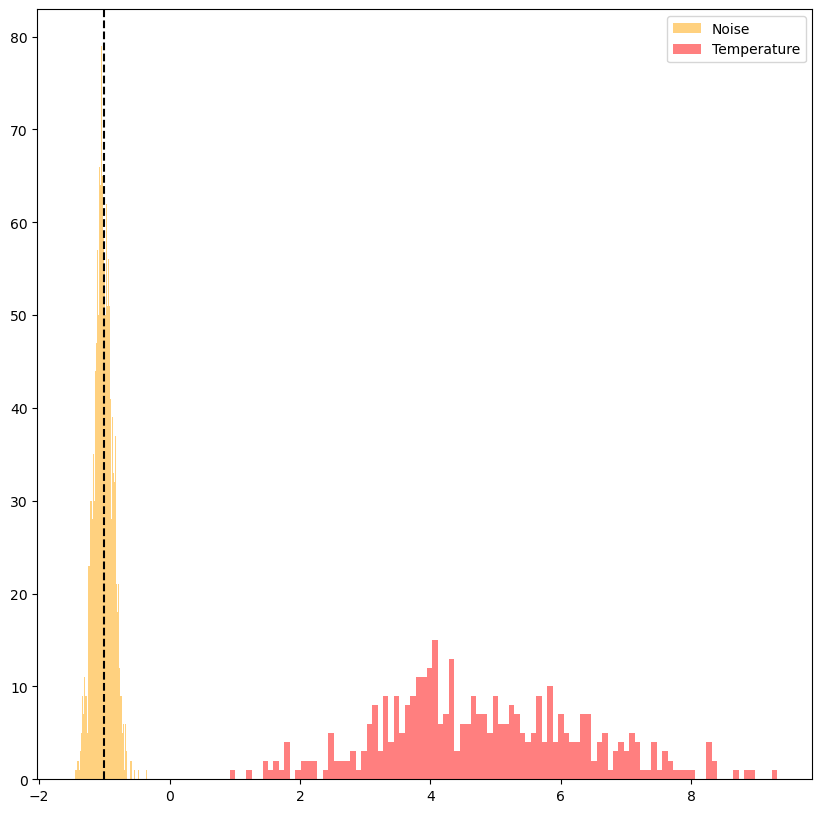

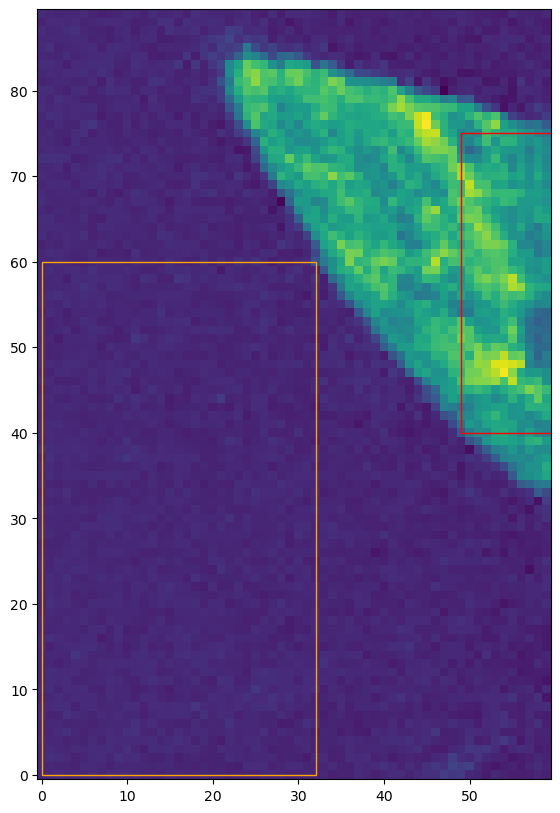

In [ ]:
examining_distributions_in_parts_of_the_predictions(predictions[date_index], (0, 32, 0, 60), (49, 60, 40, 75))

In [ ]:
times = pd.read_feather('outputs/regular_twins_map_dates.feather')
twins_files = sorted(glob.glob('../data/twins/'+'*.cdf', recursive=True))

maps = {}

for file in twins_files:
	twins_map = pycdf.CDF(file)
	for i, date in enumerate(twins_map['Epoch']):
		if len(np.unique(twins_map['Ion_Temperature'][i])) == 1:
			continue
		check = pd.to_datetime(date.strftime(format='%Y-%m-%d %H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
		if check in times.values:
			maps[check.round('T').strftime(format='%Y-%m-%d %H:%M:%S')] = {}
			maps[check.round('T').strftime(format='%Y-%m-%d %H:%M:%S')]['map'] = twins_map['Ion_Temperature'][i][:, 40:]

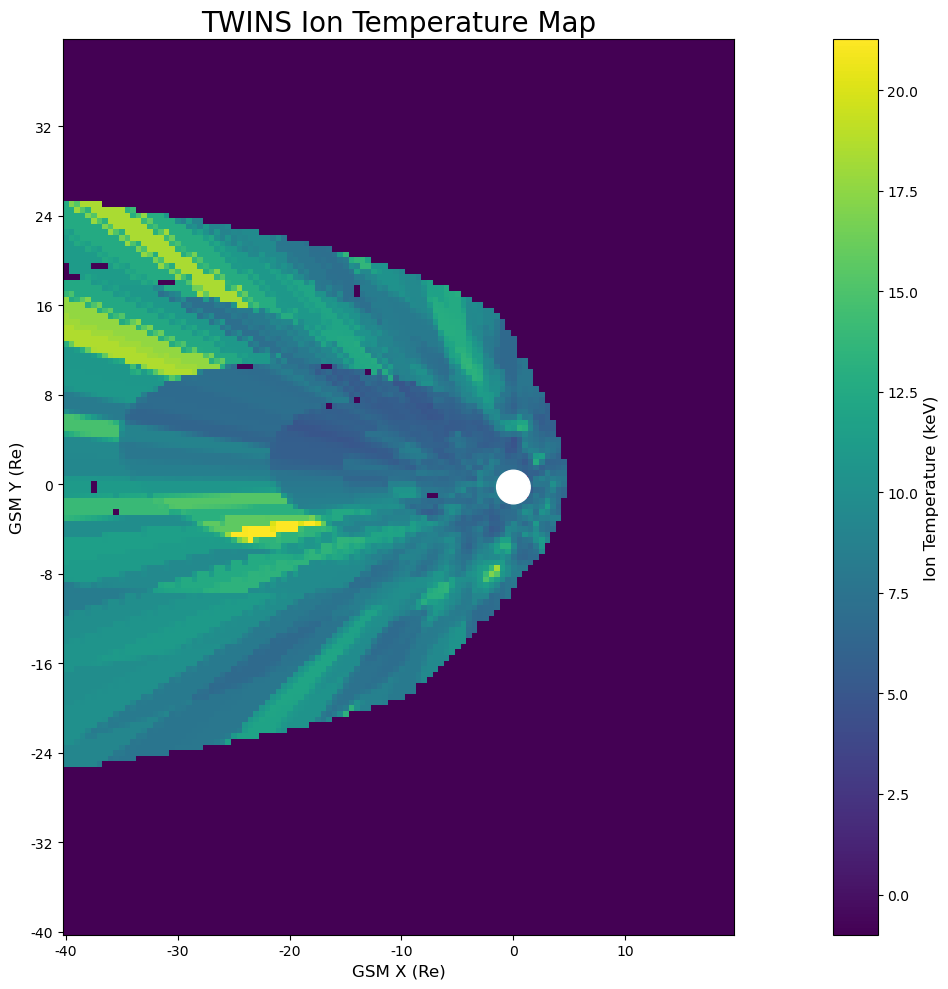

In [ ]:
xticks = np.arange(0, 120, 20)
xticklabels = np.arange(-40, 20, 10)
yticks = np.arange(0, 160, 16)
yticklabels = np.arange(-40, 40, 8)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
im = axes.imshow(maps['2012-03-07 01:50:00']['map'], origin='lower')
axes.set_title('TWINS Ion Temperature Map', fontsize=20)
circle = plt.Circle((80,79.5),3, color = 'white')
axes.add_patch(circle)
# annotating the colorbar
cbar = axes.figure.colorbar(im, ax=axes)
cbar.set_label('Ion Temperature (keV)', fontsize=12)
axes.set_xticks(xticks, xticklabels)
axes.set_yticks(yticks, yticklabels)
axes.set_xlabel('GSM X (Re)', fontsize=12)
axes.set_ylabel('GSM Y (Re)', fontsize=12)
plt.tight_layout()
plt.savefig('plots/agu_presentation_plots/twins_map_example.png')

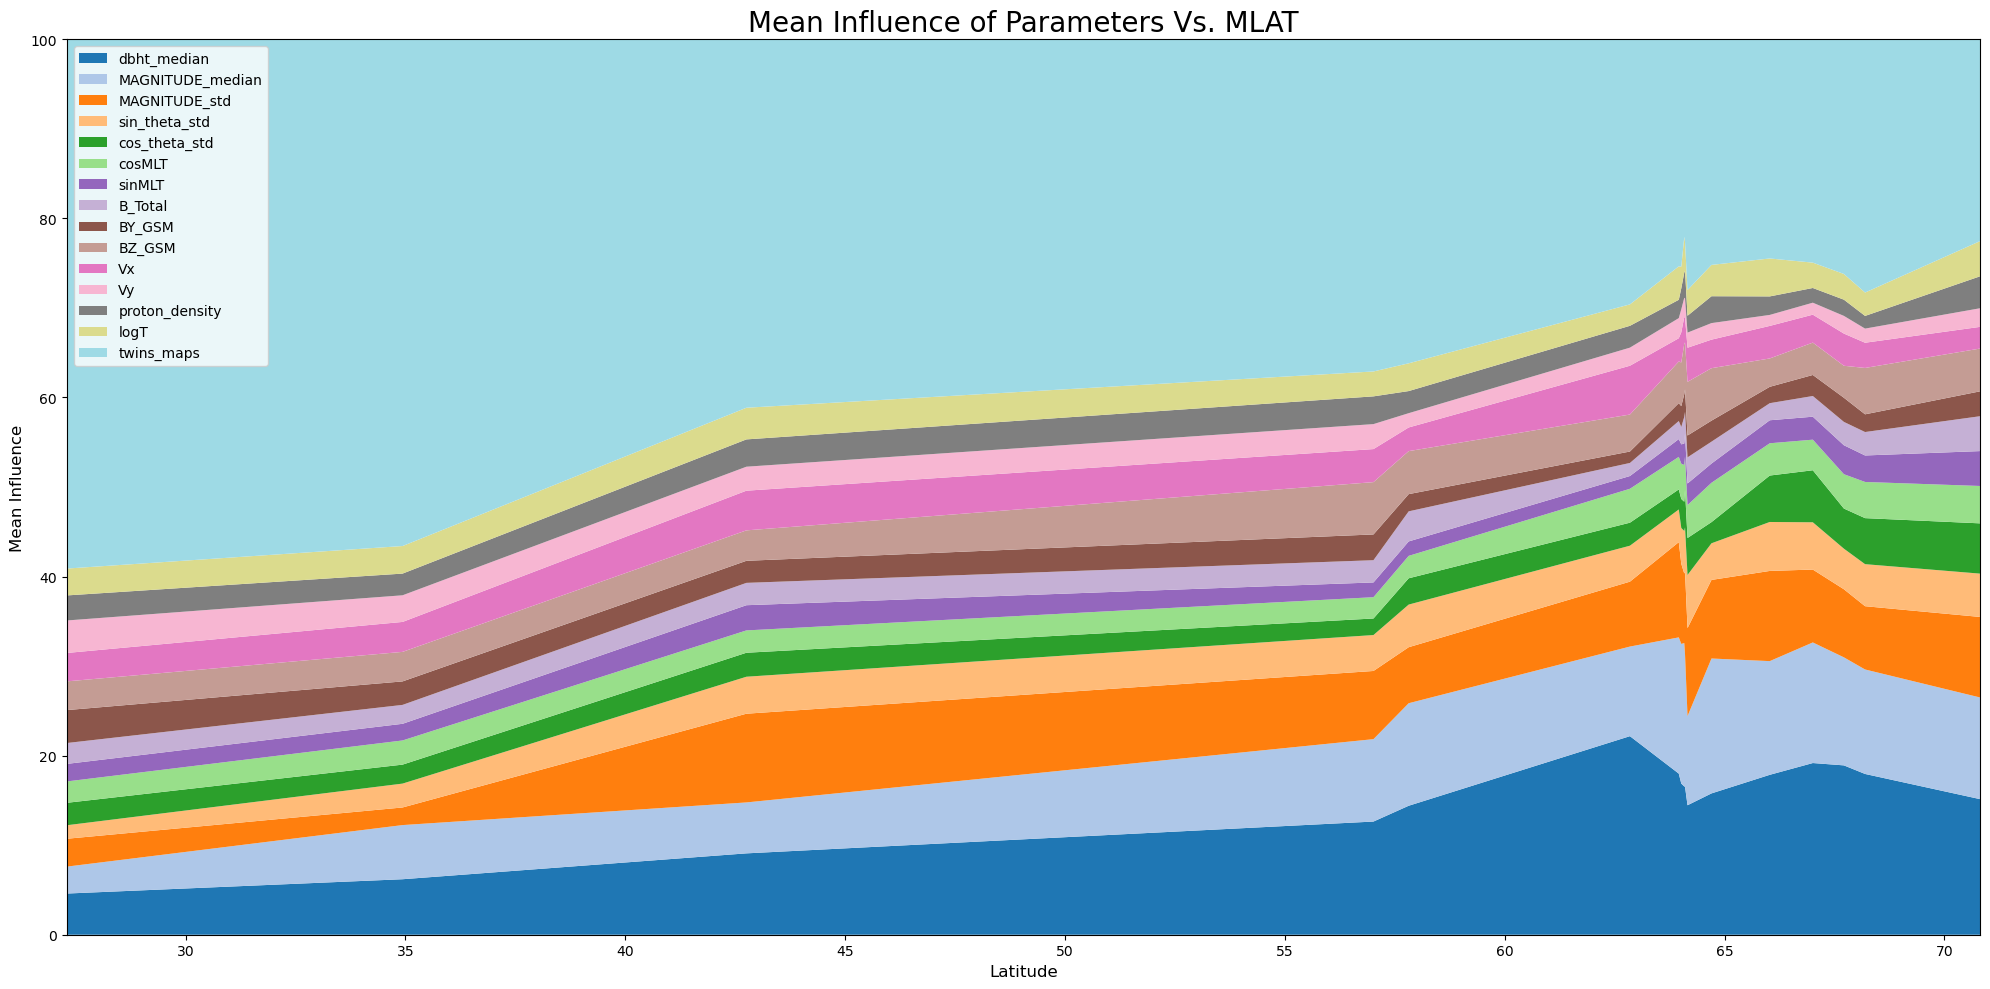

In [ ]:
# Summing up the total influence of each parameter and plotting them as a function of latitude
influence_df = pd.DataFrame(columns=[feature for feature in features], index=[twins_shap[region]['mlat'] for region in twins_shap.keys()])

for feature in features:
	feature_list = []
	for region in twins_shap.keys():
		feature_list.append(np.mean(np.sum(np.abs(twins_shap[region]['sw_mean']),axis=1)[:, features.index(feature)]))

	influence_df[feature] = feature_list

influence_df['twins_maps'] = [np.mean(np.sum(np.sum(np.abs(twins_shap[region]['twins_mean']),axis=1),axis=1)) for region in twins_shap.keys()]

adjusted_features = features.copy()
adjusted_features.append('twins_maps')

colors = sns.color_palette('tab20', len(adjusted_features)+6)
colors.pop(-1)
colors.pop(-4)
colors.pop(-4)
colors.pop(6)
colors.pop(6)
colors.pop(-2)


influence_df = influence_df.sort_index()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
axes.set_title('Mean Influence of Parameters Vs. MLAT', fontsize=20)
axes.set_ylabel('Mean Influence', fontsize=12)
axes.set_xlabel('Latitude', fontsize=12)
plotting_list = [influence_df[feature].values for feature in adjusted_features]
axes.stackplot(influence_df.index, plotting_list, labels=adjusted_features, colors=colors)
axes.margins(x=0, y=0)
axes.legend(loc='upper left')
plt.tight_layout()
plt.savefig('plots/agu_presentation_plots/twins_mean_influence.png')